# Group Work - Data Mining


## Table of Contents <a name ="TOC"></a> 

* [Data Exploration](#DE)
* [Data Preprocessing](#DP)
* [Feature Engineering](#FE)
* [Clustering](#CL)

In [1]:
# Previous installs
#!pip install dython

#### Imports


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import time
import datetime

from pandas_profiling import ProfileReport

from sklearn import tree
from sklearn.base import clone
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import dendrogram

from dython.nominal import associations
from dython import data_utils

In [3]:
donors_df = pd.read_csv("donors.csv", sep = ",", low_memory=False)

#### Variable Groups

In [4]:
# As there are many variables, create groups of variables for easier manipulation. 

# Group of variables to be used for clustering.
fields_to_keep = ["ODATEDW", "FISTDATE", "DOB", "MAXADATE"]

# Group of Variables related to File Flags.
file_flags = ["RECINHSE", "RECP3", "RECPGVG", "RECSWEEP"]

# Group of variables related to Household characteristics.
household = ["PVASTATE","HOMEOWNR","GENDER","NUMCHLD","INCOME","WEALTH1","DOMAIN"]
fields_to_keep.extend(["GENDER","NUMCHLD"])

# Group of variables related to mailing and promotions sent.
mailings = ["SOLP3","SOLIH","CARDPROM","CARDPM12","NUMPROM","NUMPRM12","HIT"]
fields_to_keep.extend(["CARDPROM","CARDPM12","NUMPROM","NUMPRM12","HIT"])

# Group of variables related to other mail offers.
other_offers = other_mails = ["MBCRAFT", "MBGARDEN", "MBBOOKS", "MBCOLECT","MAGFAML", "MAGFEM", "MAGMALE", \
               "PUBCULIN", "PUBHLTH", "PUBDOITY", "PUBNEWFN", "PUBPHOTO", "PUBOPP"]
# fields_to_keep.extend(["MBCRAFT", "MBGARDEN", "MBBOOKS", "MBCOLECT","MAGFAML", "MAGFEM", "MAGMALE"])

# Group of variables related to RFA.
rfa = ["RFA_2", "RFA_3", "RFA_4", "RFA_5", "RFA_6", "RFA_7", "RFA_8", "RFA_9", "RFA_10", "RFA_11", "RFA_12",\
                  "RFA_13", "RFA_14", "RFA_15", "RFA_16", "RFA_17", "RFA_18", "RFA_19", "RFA_20", "RFA_21", "RFA_22",\
                  "RFA_23", "RFA_24"]
fields_to_keep.extend(["RFA_2F","RFA_2A"])

# Group of variables related to Major Donors.
# "MDMAUD" on its own is useless as all of its info is already split in the other 3 variables (RFA).
mdmaud = ["MDMAUD_R","MDMAUD_F","MDMAUD_A","MAJOR"]
fields_to_keep += mdmaud

# The summary variables for giving history (excluding those we already defined to be unnecessary). 
# Tiago's note: I included CARDGIFT for now just to compare the differences between the number of lifetime gifts and the gifts \
# given in response to promotions. This won't be useful for now but later we can use its info to make some marketing reccomendations.
giving_history = ["RAMNTALL","NGIFTALL","CARDGIFT","MINRAMNT","MAXRAMNT","AVGGIFT","TIMELAG"]
fields_to_keep.extend(["AVGGIFT","RAMNTALL","NGIFTALL","CARDGIFT","TIMELAG"])



In [5]:
# Group of Variables related to Census Data of 2010. All values are respective to the donor's neighborhood.
# Take note of the number of variables. This will be reduced promptly, as we choose from these which ones we want to work with.
census =["POP901","POP902","POP903","POP90C1","POP90C2","POP90C3","POP90C4","POP90C5","ETH1","ETH2","ETH3","ETH4","ETH5","ETH6","ETH7","ETH8","ETH9","ETH10","ETH11","ETH12","ETH13","ETH14","ETH15","ETH16","AGE901","AGE902","AGE903","AGE904","AGE905","AGE906","AGE907","CHIL1","CHIL2","CHIL3","AGEC1","AGEC2","AGEC3","AGEC4","AGEC5","AGEC6","AGEC7","CHILC1","CHILC2","CHILC3","CHILC4","CHILC5","HHAGE1","HHAGE2","HHAGE3","HHN1","HHN2","HHN3","HHN4","HHN5","HHN6","MARR1","MARR2","MARR3","MARR4","HHP1","HHP2","DW1","DW2","DW3","DW4","DW5","DW6","DW7","DW8","DW9","HV1","HV2","HV3","HV4","HU1","HU2","HU3","HU4","HU5","HHD1","HHD2","HHD3","HHD4","HHD5","HHD6","HHD7","HHD8","HHD9","HHD10","HHD11","HHD12","ETHC1","ETHC2","ETHC3","ETHC4","ETHC5","ETHC6","HVP1","HVP2","HVP3","HVP4","HVP5","HVP6","HUR1","HUR2","RHP1","RHP2","RHP3","RHP4","HUPA1","HUPA2","HUPA3","HUPA4","HUPA5","HUPA6","HUPA7","RP1","RP2","RP3","RP4","MSA","ADI","DMA","IC1","IC2","IC3","IC4","IC5","IC6","IC7","IC8","IC9","IC10","IC11","IC12","IC13","IC14","IC15","IC16","IC17","IC18","IC19","IC20","IC21","IC22","IC23","HHAS1","HHAS2","HHAS3","HHAS4","MC1","MC2","MC3","TPE1","TPE2","TPE3","TPE4","TPE5","TPE6","TPE7","TPE8","TPE9","PEC1","PEC2","TPE10","TPE11","TPE12","TPE13","LFC1","LFC2","LFC3","LFC4","LFC5","LFC6","LFC7","LFC8","LFC9","LFC10","OCC1","OCC2","OCC3","OCC4","OCC5","OCC6","OCC7","OCC8","OCC9","OCC10","OCC11","OCC12","OCC13","EIC1","EIC2","EIC3","EIC4","EIC5","EIC6","EIC7","EIC8","EIC9","EIC10","EIC11","EIC12","EIC13","EIC14","EIC15","EIC16","OEDC1","OEDC2","OEDC3","OEDC4","OEDC5","OEDC6","OEDC7","EC1","EC2","EC3","EC4","EC5","EC6","EC7","EC8","SEC1","SEC2","SEC3","SEC4","SEC5","AFC1","AFC2","AFC3","AFC4","AFC5","AFC6","VC1","VC2","VC3","VC4","ANC1","ANC2","ANC3","ANC4","ANC5","ANC6","ANC7","ANC8","ANC9","ANC10","ANC11","ANC12","ANC13","ANC14","ANC15","POBC1","POBC2","LSC1","LSC2","LSC3","LSC4","VOC1","VOC2","VOC3","HC1","HC2","HC3","HC4","HC5","HC6","HC7","HC8","HC9","HC10","HC11","HC12","HC13","HC14","HC15","HC16","HC17","HC18","HC19","HC20","HC21","MHUC1","MHUC2","AC1","AC2",
]
len(census)

286

## Data Exploration and PreProcessing<a name ="DE"></a> 

* ###### [RFA](#RFA)
* ###### [Giving History](#GH)
* ###### [Household Variables](#Household)
* ###### [MDMAUD](#MDMAUD)
* ###### [Mailings](#Mailings)
* ###### [Other Mail Offers](#Other_mail)
* ###### [File Flags](#Flags)
* ###### [Census Data](#Census)
* ###### [Fields to Keep](#Fieldstokeep)

In [6]:
donors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95412 entries, 0 to 95411
Columns: 476 entries, Unnamed: 0 to GEOCODE2
dtypes: float64(49), int64(302), object(125)
memory usage: 346.5+ MB


<p>Observations: 95412<br>
Variables / Columns: 475</p>

In [7]:
donors_df.head(10)

,Unnamed: 0,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,...,AVGGIFT,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,0,2009-01-01,GRI,0,IL,61081,,,1957-12-01,0,...,7.741935,95515,0,L,4,E,X,X,X,C
1,1,2014-01-01,BOA,1,CA,91326,,,1972-02-01,0,...,15.666667,148535,0,L,2,G,X,X,X,A
2,2,2010-01-01,AMH,1,NC,27017,,,NaN,0,...,7.481481,15078,1,L,4,E,X,X,X,C
3,3,2007-01-01,BRY,0,CA,95953,,,1948-01-01,0,...,6.812500,172556,1,L,4,E,X,X,X,C
4,4,2006-01-01,,0,FL,33176,,,1940-01-01,0,...,6.864865,7112,1,L,2,F,X,X,X,A
5,5,2014-01-01,CWR,0,AL,35603,,,NaN,0,...,12.750000,47784,0,L,1,F,X,X,X,C
6,6,2007-01-01,DRK,0,IN,46755,,,1980-01-01,0,...,7.642857,62117,1,L,1,E,X,X,X,D
7,7,2014-01-01,NWN,0,LA,70611,,,NaN,0,...,6.200000,109359,1,L,3,E,X,X,X,C
8,8,2008-01-01,LIS,1,IA,51033,,,NaN,0,...,18.090909,75768,1,L,1,F,X,X,X,D
9,9,2014-01-01,MSD,1,TN,37127-,,,1952-11-01,0,...,9.333333,49909,0,L,1,F,X,X,X,B


### **NaN and empty values**

Apart from a few variables, any records with " " or "" are considered missing values. Some binary variables explictly use " " for one of their classes; they are:

NOEXCH, RECINHSE, RECP3, RECPGVG, RECSWEEP, MAJOR;<br>

Because of this, we change them right now.


In [8]:
# Doing this with a for loop is the only thing that works for me. Using replace directly on the dataframe doesn't, for some reason.
for column in ["NOEXCH"]:
    donors_df[column].replace({" ":"1","X":"0"},inplace=True)
    
for column in ["MAJOR","RECINHSE", "RECP3","RECPGVG", "RECSWEEP"]:
    donors_df[column].replace({" ":"0","X":"1"},inplace=True)

Some categorical variables use " " for one of their classes, as well as 0. They are:

* SOLP3 - only has 180 non-null values which means that there are 180 donors with the NOT default mailing configuration. 
* SOLIH - only has 6200 non-null values which means that there are 6200 donors with the NOT default mailing configuration.

Both have no missing values, and " " means they can be mailed.  Therefore, they'll be replaced by the arbitrary number "99", as the default mail soliciting per year is unknown.

In [9]:
donors_df.SOLP3.replace(" ",99, inplace = True)
donors_df.SOLIH.replace(" ",99, inplace = True)

In [10]:
# Check if any variables have NaNs, and " ". If they do, we need to look at the why before we go filling the spaces up.
# temp_df = pd.DataFrame([donors_df[fields_to_keep].isna().sum(),(donors_df[fields_to_keep]==" ").sum()]).T
# temp_df[(temp_df[0]>0) & (temp_df[1]>0)]

Variables either have NaNs or " ", so we can replace the rest of them now.

In [11]:
donors_df.replace("", np.nan, inplace=True) # Tiago: I think that this line is also unnecessary because all "" show as NaNs by default. 
donors_df.replace(" ", np.nan, inplace=True)
donors_df = donors_df.fillna(value=np.nan) # Tiago: do we actually need this line for anything?

In [12]:
# Check for duplicated records
donors_df.duplicated().sum()

0

From now on, we deal with missing values / info on a feature case-by-case basis.

### **Datetime variables**

Convert variables to datetime. These are:
ODATEDW, FISTDATE, LASTDATE


As this dataset has data up to 2017, including promotions sent during the year, we assume the current date is the first day of 2018.

In [13]:
donors_df.loc[:,"ODATEDW"] = pd.to_datetime(donors_df["ODATEDW"],infer_datetime_format=True)
donors_df.loc[:,"FISTDATE"] = pd.to_datetime(donors_df["FISTDATE"],format="%Y-%m")
donors_df.loc[:,"LASTDATE"] = pd.to_datetime(donors_df["LASTDATE"],format="%Y-%m-%d")

current_time = pd.to_datetime("2018-01-01",format="%Y-%m-%d")

In [14]:
# Deal with missing values. For first date and odatedw, FISTDATE has 2 missing values, and ODATEDW has none, so we can use the values of ODATEDW to fill those in.
donors_df.loc[:,"FISTDATE"][donors_df["FISTDATE"].isna()] = donors_df.loc[:,"ODATEDW"][donors_df["FISTDATE"].isna()]

C:\Users\Tiago\.conda\envs\datamining\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### **Exploring RFA** <a name="RFA"></a>
<font size="2">
First Byte Recency. Follows the following:
    
* F=FIRST TIME DONOR Anyone who has made their first donation in the last 6 months and has made just one donation.
* N=NEW DONOR Anyone who has made their first donation in the last 12 months and is not a First time donor. This is everyone who made their first donation 7-12 months ago, or people who made their first donation between 0-6 months ago and have made 2 or more donations.
* A=ACTIVE DONOR Anyone who made their first donation more than 12 months ago and has made a donation in the last 12 months.
* L=LAPSING DONOR A previous donor who made their last donation between 13-24 months ago.
* I=INACTIVE DONOR A previous donor who has not made a donation in the last 24 months. It is people who made a donation 25+ months ago.
* S=STAR DONOR STAR Donors are individuals who have given to 3 consecutive card mailings.

Second byte, frequency:
Second Byte of code is concerned with FREQUENCY based on the period of recency. The period of recency for all groups except L and I is the last 12 months. For L it is 13-24 months ago, and for I it is 25-36 months ago. There are four valid frequency codes.
* 1=One gift in the period of recency
* 2=Two gift in the period of recency
* 3=Three gifts in the period of recency
* 4=Four or more gifts in the period of recency

Third byte of the code is the Amount of the last gift.
* A= 0.01 - 1.99
* B= 2.00 - 2.99
* C= 3.00 - 4.99
* D= 5.00 - 9.99
* E= 10.00 -14.99
* F= 15.00 -24.99
* G= 25.00 and above

Additionally, the fields are respective to certain years as such:
* 2014: RFA_23 and 24.
* 2015: 13 to 22.
* 2016: 3 to 12.
* 2017: 2.
</font>

In [15]:
## RFA 

print(donors_df[rfa].head())

print(donors_df[rfa].replace(" ",np.nan).isna().sum()) 
# While there are no NaNs or "" (I checked beforehand), there are a lot of empty records. We have little over 95k observations, so RFA20 and 23 have \
# basically half of the data missing. This is consistent with the yearly limit some donors have on solicitation mailing. My interpretation is that " " means \
# they weren't sent the mailing, even though that shouldn't interfere with their RFA status.

# Tiago's suggestion: let's focus only on RFA_2 as it is both the most recent and most complete feature. However, we don't need to include RFA_2R, as that will always be L.
# Later on it may make sense to extend the study to include RFA_3 and analyse the behaviour of donors from 2016 to 2017.
# If so, Pandas has a few methods such as interpolate to derive the missing data for these cases - check https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html.

  RFA_2 RFA_3 RFA_4 RFA_5 RFA_6 RFA_7 RFA_8 RFA_9 RFA_10 RFA_11  ... RFA_15  \
0   L4E   S4E   S4E   S4E   S4E   S4E   S4E   S4E    S4E    S4E  ...    S4E   
1   L2G   A2G   A2G   A2G   A2G   A1E   A1E   A1E    A1E    A1E  ...    NaN   
2   L4E   S4E   S4E   S4E   S4E   S4F   S4F   S4F    NaN    S4F  ...    S4F   
3   L4E   S4E   S4E   S4E   S4E   S4E   S4E   S4E    NaN    S4E  ...    S4E   
4   L2F   A2F   A2F   A2F   A1D   I2D   A1E   A1E    L1D    A1E  ...    NaN   

  RFA_16 RFA_17 RFA_18 RFA_19 RFA_20 RFA_21 RFA_22 RFA_23 RFA_24  
0    S4E    S4E    S4E    S4E    S4E    S4E    S4E    S4E    S4E  
1    L1E    NaN    NaN    N1E    N1E    N1E    N1E    NaN    F1E  
2    S4F    NaN    S4D    S4D    NaN    NaN    S4D    S4D    S3D  
3    S4E    S2D    S2D    A1D    A1D    A1D    A1D    NaN    NaN  
4    L3D    A2D    A2D    A3D    A3D    A3D    I4E    A3D    A3D  

[5 rows x 23 columns]
RFA_2         0
RFA_3      1950
RFA_4      2312
RFA_5     33590
RFA_6      3557
RFA_7      8874
RFA_

In [16]:
# Taking note that the dataset is composed of only lapsed donors.
donors_df["RFA_2"].str.split("",expand=True).iloc[:,1].value_counts()

L    95412
Name: 1, dtype: int64

---

### **Exploring Giving History**<a name="GH"></a>

Just the summary variables. We have agreed the others are very likely not important (as we are more interested in lifetime metrics).<br><br>
<font size="2">
RAMNTALL                    Dollar amount of lifetime gifts to date<br>
NGIFTALL                    Number of lifetime gifts to date<br>
CARDGIFT                    Number of lifetime gifts to card promotions to date<br>
MINRAMNT                    Dollar amount of smallest gift to date<br>
MAXRAMNT                    Dollar amount of largest gift to date<br>
TIMELAG                     Number of months between first and second gift<br>
AVGGIFT                     Average dollar amount of gifts to date<br> </font>

In [17]:
# Check one time donors.
print("{} of donors gave only once.".format(donors_df[donors_df["NGIFTALL"]==1].index.shape[0]))

10008 of donors gave only once.


In [18]:
print(donors_df[giving_history].info())

# As these are metric features, we can describe them.
donors_df[giving_history].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95412 entries, 0 to 95411
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RAMNTALL  95412 non-null  float64
 1   NGIFTALL  95412 non-null  int64  
 2   CARDGIFT  95412 non-null  int64  
 3   MINRAMNT  95412 non-null  float64
 4   MAXRAMNT  95412 non-null  float64
 5   AVGGIFT   95412 non-null  float64
 6   TIMELAG   85439 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 5.1 MB
None


,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,AVGGIFT,TIMELAG
count,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,85439.000000
mean,104.489351,9.602031,5.058242,7.933656,19.999790,13.347786,8.093739
std,118.580367,8.554342,4.526651,8.784231,25.067746,10.769997,8.213242
min,13.000000,1.000000,0.000000,0.000000,5.000000,1.285714,0.000000
25%,40.000000,3.000000,2.000000,3.000000,14.000000,8.384615,4.000000
50%,78.000000,7.000000,4.000000,5.000000,17.000000,11.636364,6.000000
75%,131.000000,13.000000,7.000000,10.000000,23.000000,15.477955,11.000000
max,9485.000000,237.000000,41.000000,1000.000000,5000.000000,1000.000000,1088.000000


In [19]:
# Inconsistencies: MINRAMOUNT==0
donors_df[giving_history][donors_df["MINRAMNT"]==0]

,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,AVGGIFT,TIMELAG
310,100.0,1,1,0.0,100.0,100.000000,12.0
1125,136.0,20,2,0.0,11.0,6.800000,10.0
1814,368.0,27,13,0.0,20.0,13.629630,8.0
2130,229.0,25,12,0.0,18.0,9.160000,15.0
2165,125.0,4,1,0.0,50.0,31.250000,1.0
...,...,...,...,...,...,...,...
94753,93.0,7,4,0.0,18.0,13.285714,15.0
94870,96.0,10,2,0.0,18.0,9.600000,4.0
95025,211.0,25,9,0.0,15.0,8.440000,6.0
95151,345.0,14,5,0.0,50.0,24.642857,12.0


MINRAMNT==0 seems like a clear error in data. It has 584 rows. As we don't plan on using this variable, leave it as it is for now.

In [20]:
print("Index of:")
print("Record which has given the most gifts: {}".format(donors_df["NGIFTALL"].idxmax()))
print("Record of the largest cumulative sum of lifetime gifts: {}".format(donors_df["RAMNTALL"].idxmax()))
print("Record of the largest average gift: {}".format(donors_df["AVGGIFT"].idxmax()))
print("Record of the largest gift ever: {}".format(donors_df["MAXRAMNT"].idxmax()))

Index of:
Record which has given the most gifts: 31516
Record of the largest cumulative sum of lifetime gifts: 17612
Record of the largest average gift: 14430
Record of the largest gift ever: 17612


In [21]:
# I tried a few plots and I think boxplots are still the most visible ones, but they don't offer too much information on top of the above.

#fig, ax = plt.subplots(nrows=len(giving_history),figsize=(18,len(giving_history)*4))
#sns.set_theme()
#
#for i,column in enumerate(donors_df[giving_history].columns):
#    sns.boxplot(data=donors_df[column],x=donors_df[column],ax=ax[i])
#plt.suptitle("Box Plots of Giving History Variables", fontsize=12)
#fig.subplots_adjust(top=0.95)
#plt.show()
#
# Takes a while to run so we can comment it out for now.

In [22]:
# Outlier detection and quantification.
# Manual filters first.

filters1 = (
    (donors_df['RAMNTALL']<=1000) & (donors_df['NGIFTALL']<=35) &
    (donors_df['MAXRAMNT']<=500) & (donors_df['AVGGIFT']<=100) &
    (donors_df['TIMELAG']<=100)
)

df_1 = donors_df[filters1]

remove_nr = np.round(df_1.shape[0] / donors_df.shape[0], 4)
print('Manually removing outliers from this group would remove {}% of the data.'.format(np.round((1-remove_nr)*100),3))

# IQR method second.
q25 = donors_df.quantile(.25)
q75 = donors_df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for feat in giving_history:
    llim = lower_lim[feat]
    ulim = upper_lim[feat]
    filters2.append(donors_df[feat].between(llim, ulim, inclusive=True))

filters2 = pd.Series(np.all(filters2, 0))
df_2 = donors_df[filters2]

remove_nr = np.round(df_2.shape[0] / donors_df.shape[0], 4)
print('Removing outliers with the IQR method from this group would remove {}% of the data.'.format(np.round((1-remove_nr)*100),3))

Manually removing outliers from this group would remove 12.0% of the data.
Removing outliers with the IQR method from this group would remove 27.0% of the data.


These numbers are very worrisome. Most of these outliers come from timelag. Clustering solutions will be very difficult to apply under these conditions, so we must do something about outliers. We will do so later, after clearly defining the variables we want to work with.

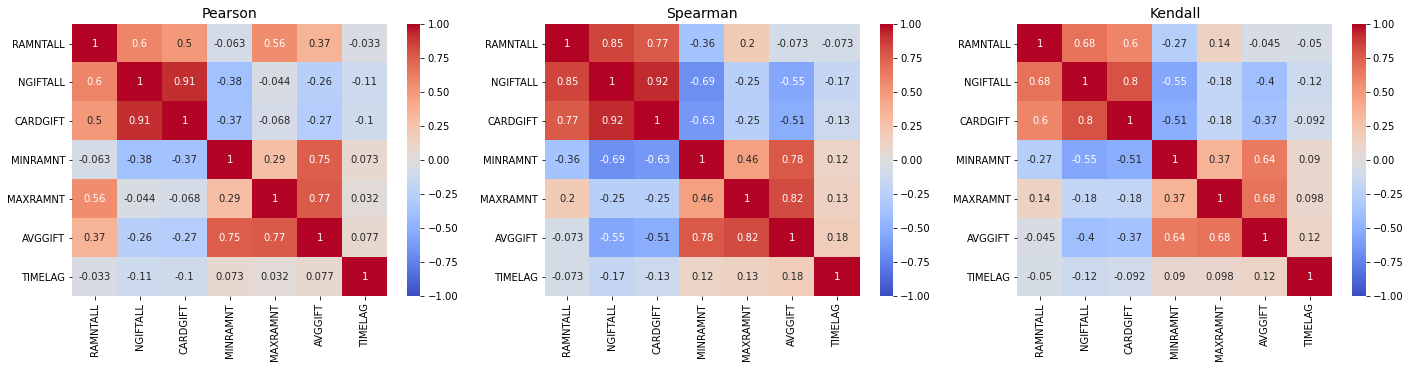

In [23]:
fig, ax = plt.subplots(ncols=3,figsize=(24,5))

for i,method in enumerate(["pearson","spearman","kendall"]):
    sns.heatmap(donors_df[giving_history].corr(method=method),annot=True,vmin=-1,vmax=1,ax=ax[i],cmap="coolwarm")
    ax[i].set_title(method.capitalize(),fontsize=14)

plt.show()
# As we can see below,, MIN and MAX amounts of gifts have little interesting information for clustering, as they have very poor correlation with everything except \
# features that are directly based off of them (like AVGGIFT or RAMNTALL).
# Moreover, while RAMNTALL is correlated with the amount of times someone donates, it is less correlated with the avg gift amount. I thought that was curious, but \
# not too insightful in itself.
# I also want to point out that RAMNTALL has a 0.6 corr with NGIFTALL, which has a 0.91 corr with CARDGIFT. That is to say, 90% of all gifted amounts originated \
# in promotions.

In [24]:
# sns.pairplot(donors_df[giving_history]) # This takes very long, hence being commented out.

Tiago: I also plotted a pairplot to see scatterplots but the heatmap is both faster and more readable.

For clustering, I reccomend we keep RAMNTALL and NGIFTALL, and AVGGIFT.

MAXRAMNT and MINRAMNT seem interesting, but I'm not sure how useful they are. Moreover MINRAMNT has missing data. The max and minimum amount have very poor corrleation with the amount of times one donates. Even for non-linear relationships, I only see MINRAMNT for amount of gifts, which makes some intuitve type of sense.

---

### **Exploring Census Data** <a name ="Census"></a> 

The census data is from 2010 and pertains to neighborhood metrics. 
As such, its usefulness may be limited by the volatility of some features (a lot can change in 7 years), and any interpretations made with the data must take both these factors into consideration. These points notwithstanding, we can still derive some relevant insights from using some of them in our clustering: 
1. characteristics of a neighborhood are reflective of their household constituents; 
2. considering PVA's chosen communication channel (mailing), and assuming a donor's behavior is similar to its neighborhood in this regard, being able to estabilish meaningful links between a donor and its neighborhood has tremendous informative power.

Before we move on, it is relevant to mention the documentation has a variable describing the geography level match of the record to the census data, GEOCODE. However, as more than 80k of its values are NaN, and because the documentation does not provide a clear interpretation of the available values, we choose to not use it.

In [25]:
# Summarily describe the first three columns of the census data.
donors_df[["POP901","POP902","POP903"]].rename(columns={"POP901":"Nr of persons","POP902":"Nr of families","POP903":"Nr of Households"}).describe()

,Nr of persons,Nr of families,Nr of Households
count,95412.000000,95412.000000,95412.000000
mean,3255.880204,864.993083,1222.573460
std,5743.217266,1458.103434,2123.096242
min,0.000000,0.000000,0.000000
25%,990.000000,265.000000,377.000000
50%,1565.000000,421.000000,585.000000
75%,3091.000000,840.000000,1165.000000
max,98701.000000,23766.000000,35403.000000


In [26]:
# Which of the Census data features have missing values?
donors_df[census].isna().sum()[donors_df[census].isna().sum()>0]
# MSA, ADI, DMA have explicit missing values. These columns can be dropped, in any case.

MSA    132
ADI    132
DMA    132
dtype: int64

In [27]:
# Describe some representative variables of the census data.
temp_census = [["POP901","POP902","POP903","POP90C1","POP90C4",
"AGE901","AGE904","AGE907",
"HHN3",
"MARR1"],
["HHP2",
"HV1","HV2",
"HVP2",
"RHP1","RHP2","RHP3","RHP4"],
["HHAS4",
"TPE10","TPE11",
"LFC1","LFC4","LFC5",
"OEDC7",
"EC1","SEC1","SEC2"],
["AFC1","AFC4",
"VOC1",
"HC1","MHUC1","MHUC2"]]

for l in temp_census:
    print("\nOutput:")
    print(donors_df[l].describe())


Output:
             POP901        POP902        POP903       POP90C1       POP90C4  \
count  95412.000000  95412.000000  95412.000000  95412.000000  95412.000000   
mean    3255.880204    864.993083   1222.573460     58.589653     48.211724   
std     5743.217266   1458.103434   2123.096242     47.430774      5.565579   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      990.000000    265.000000    377.000000      0.000000     47.000000   
50%     1565.000000    421.000000    585.000000     99.000000     49.000000   
75%     3091.000000    840.000000   1165.000000     99.000000     50.000000   
max    98701.000000  23766.000000  35403.000000     99.000000     99.000000   

             AGE901        AGE904        AGE907          HHN3         MARR1  
count  95412.000000  95412.000000  95412.000000  95412.000000  95412.000000  
mean      34.475276     35.917379     24.515092     42.697428     58.100616  
std        8.335618      7.261215      7.5152

Notable issues:
* ###### There's neighborhoods with 0 people in it. There's also neighborhoods with only one household on it, or one man, or one woman.
* ###### POP90C1 looks okay to use; but its basically a binary variable. Either the nighborhood is urbanized or not. 
* ###### POP90C4: This is the percentage of males. There's both neighborhoods with all males and all females.
* ###### AGE901 = AGE904, both are normally distributed.
* ###### AGE907: would like to turn this around, get percentage of adults in the neighborhood.7
* ###### HHN3: Percentage of 3+ ppl households: I like this, but it's basically a binarization of avg people per household. No reason to keep it.
* ###### MARR1: also looks fine.
* ###### hhp2: Average person per household. Shocked me. The values for this are in the hundreds. I don't know what they define as household, but even buildings don't have upwards of 259 people. Upon a quick google search, the most lilely scenario is that due to some mistake this number was multiplied by 100, which is consistent with the official data available on the internet (2.58 people per household). So if we use this, correct it!!
* ###### HV1 and HV2, median/avg home values are close, so can use just one. 
* ###### HVP2: is related to HV. My problem is that if HV2 is to be trusted, then this percentage is wrong? Because the median / average value of homes is much more than 200k. Instead, HVP2 is highly skewed, meaning lots of homes are valued at less than 200k. So I am unsure of this metric.
* ###### RHP1 Number of Rooms per Housing Unit. Given the high number I will just go ahead and assume housing unit = building or block.  As these variables relating to housing units, I'd rather just use the rhp4 var: avg # of ppl per room. That's a good metric of how cramped families ar ein their household.
* ###### HHAS4: Is also a good metric of poverty level. Use. 
* ###### TPE10: It's very surprising that the max avg travel time to work is 90 minutes. On the other hand, given the size of the neighborhoods, it's a very interesting metric.
* ###### LFC: I'd rather use LFC1 which is percentage of adults in labor force. 
* ###### OEDC7: is just another measure of poverty, but it's ftrankly useless, given the low values. Discard.
* ###### EC1: Something is very wrong with this variable. Median years of school completed. The lowest quantile being 120, while we know the mandatory education years is 12, implies the numbers here are multiplied by 10. Correct it to use it.
* ###### SEC: Values seem too insignificant to be relevant.
* ###### AFCs: I want to keep this given the subject matter of this dataset. 
* ###### VOC1: So almost all households have 1 vehicle. Still may be useful. 
* ###### HC1: While this points to years of residency, "percent median length of residence" seems to instead imply this is the percentage of people belonging to some metric (median) of length of residence. Which is sketchy. As such, it is better to exclude.
* ###### MHUC: I doubt the homeowner cost is single digit dollars. But I also don't know how this is measured, so I would say to discard these variables.

In summary:
* There's obvious outliers or wrong information. Some 0s are impossible and although 99s are possible, they may be unlikely.
* HHP2 and EC1 need to be fixed before use.
* Suitable for clustering: POP903,AGE901,AGE907,HHN3,MARR1,HHP2,HV,ETHC,RHP4,HHAS4,TPE10,LFC1,EC1,AFC,VOC1.
* IC4 should also be used, as we have already discussed: it is useful in predicting richness features we explored previously and a metric feature.

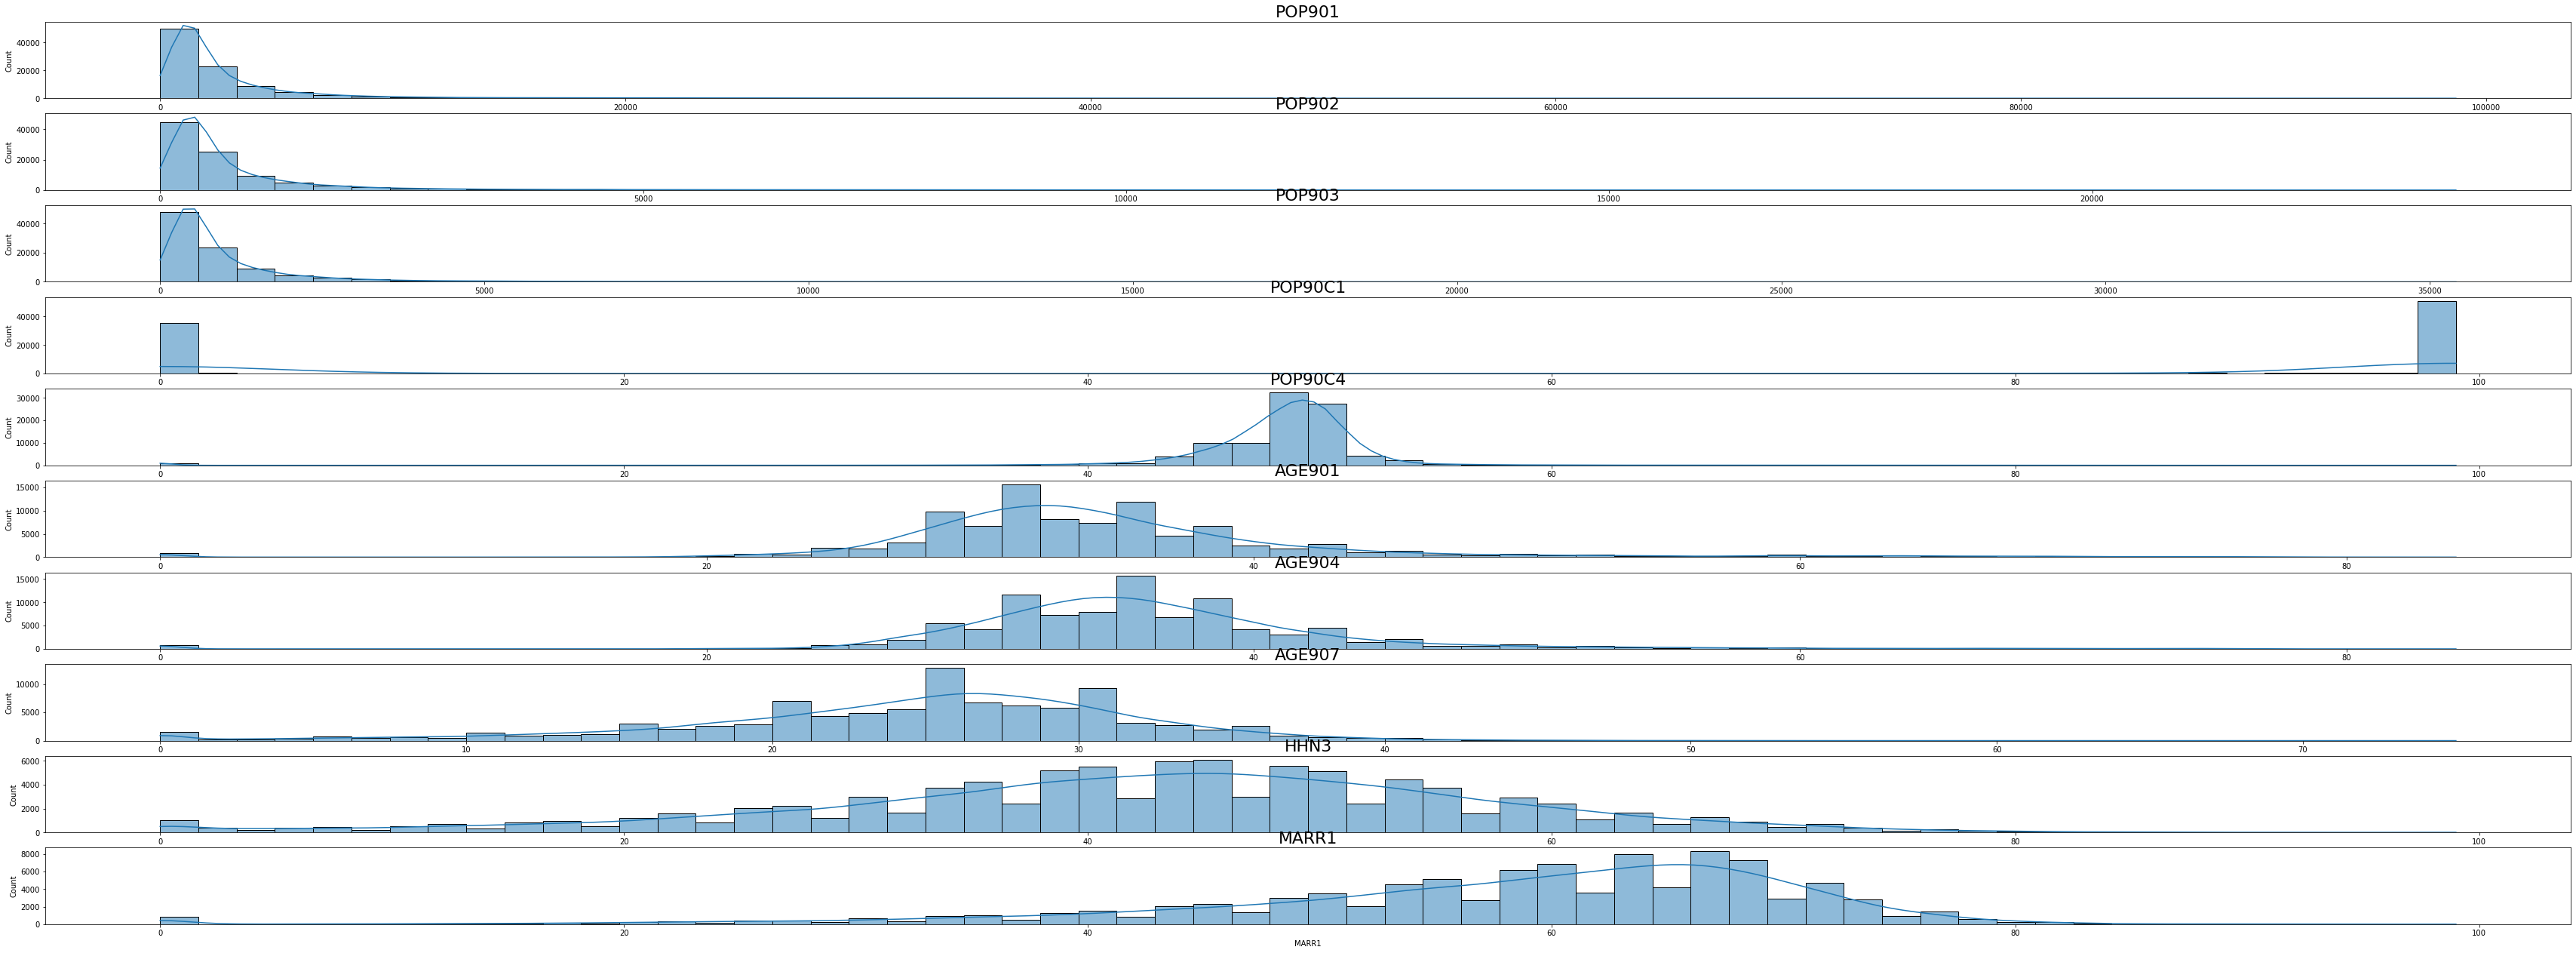

In [28]:
# Plot distributions of these ethnicity variables.
fig, axs = plt.subplots(nrows = len(temp_census[0]), figsize = (60, 22), sharex= False)

for i, l in enumerate(temp_census[0]):
    sns.histplot(data=donors_df[l],bins= 60,kde=True, ax = axs[i])
    axs[i].set_title(l, size = 22)
    
plt.show()

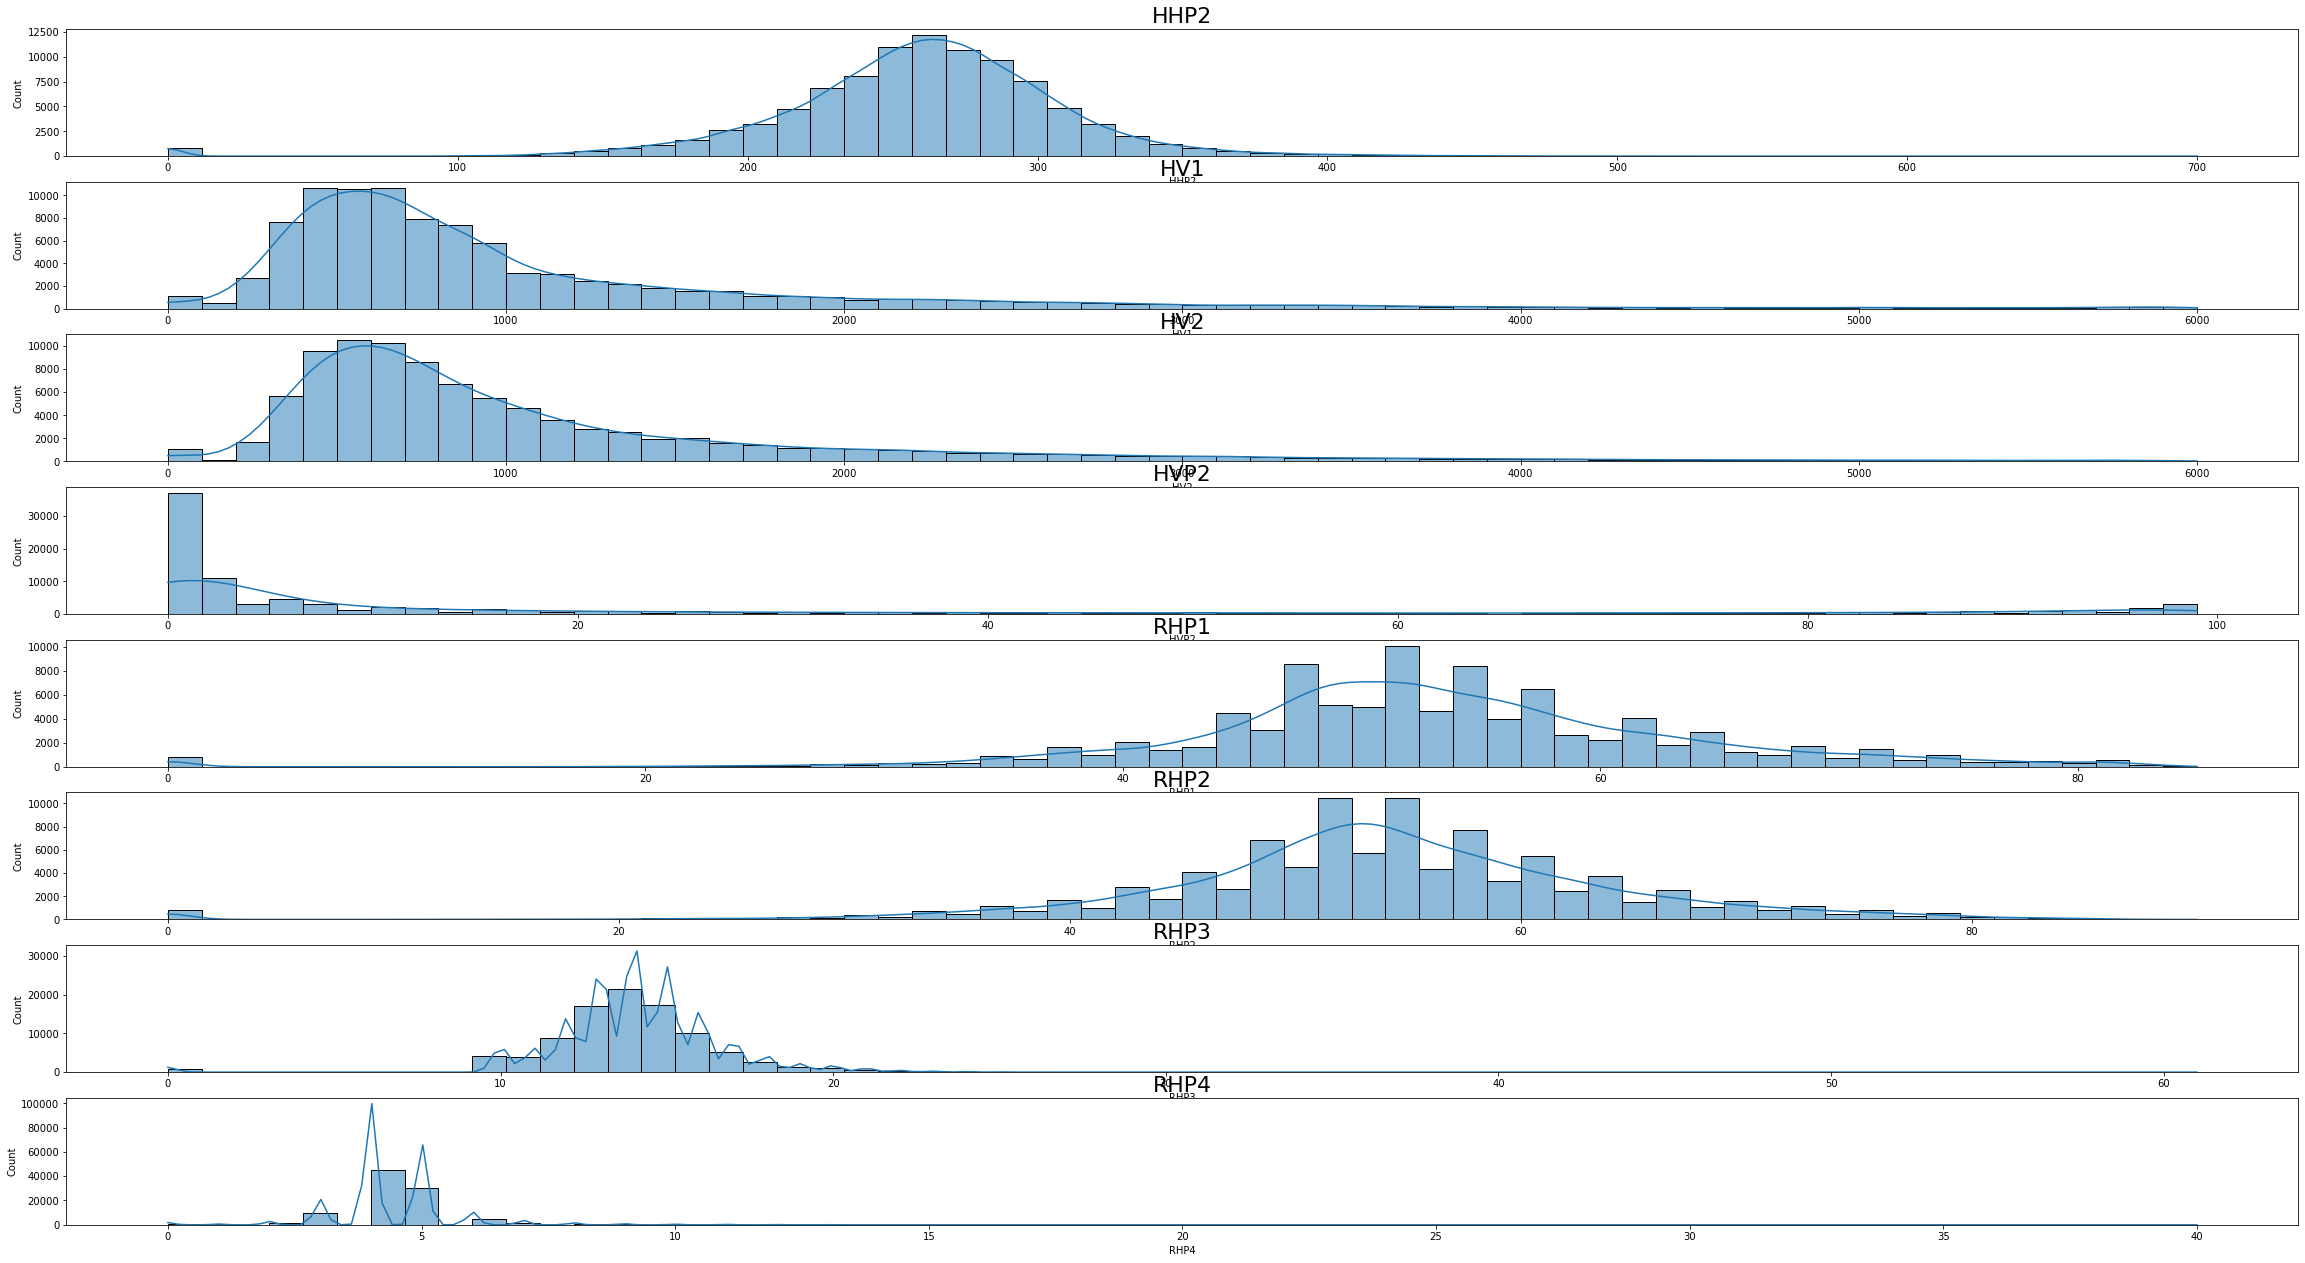

In [29]:
# Plot distributions of these ethnicity variables.
fig, axs = plt.subplots(nrows = len(temp_census[1]), figsize = (40, 22), sharex= False)

for i, l in enumerate(temp_census[1]):
    sns.histplot(data=donors_df[l],bins= 60,kde=True, ax = axs[i])
    axs[i].set_title(l, size = 22)
plt.show()

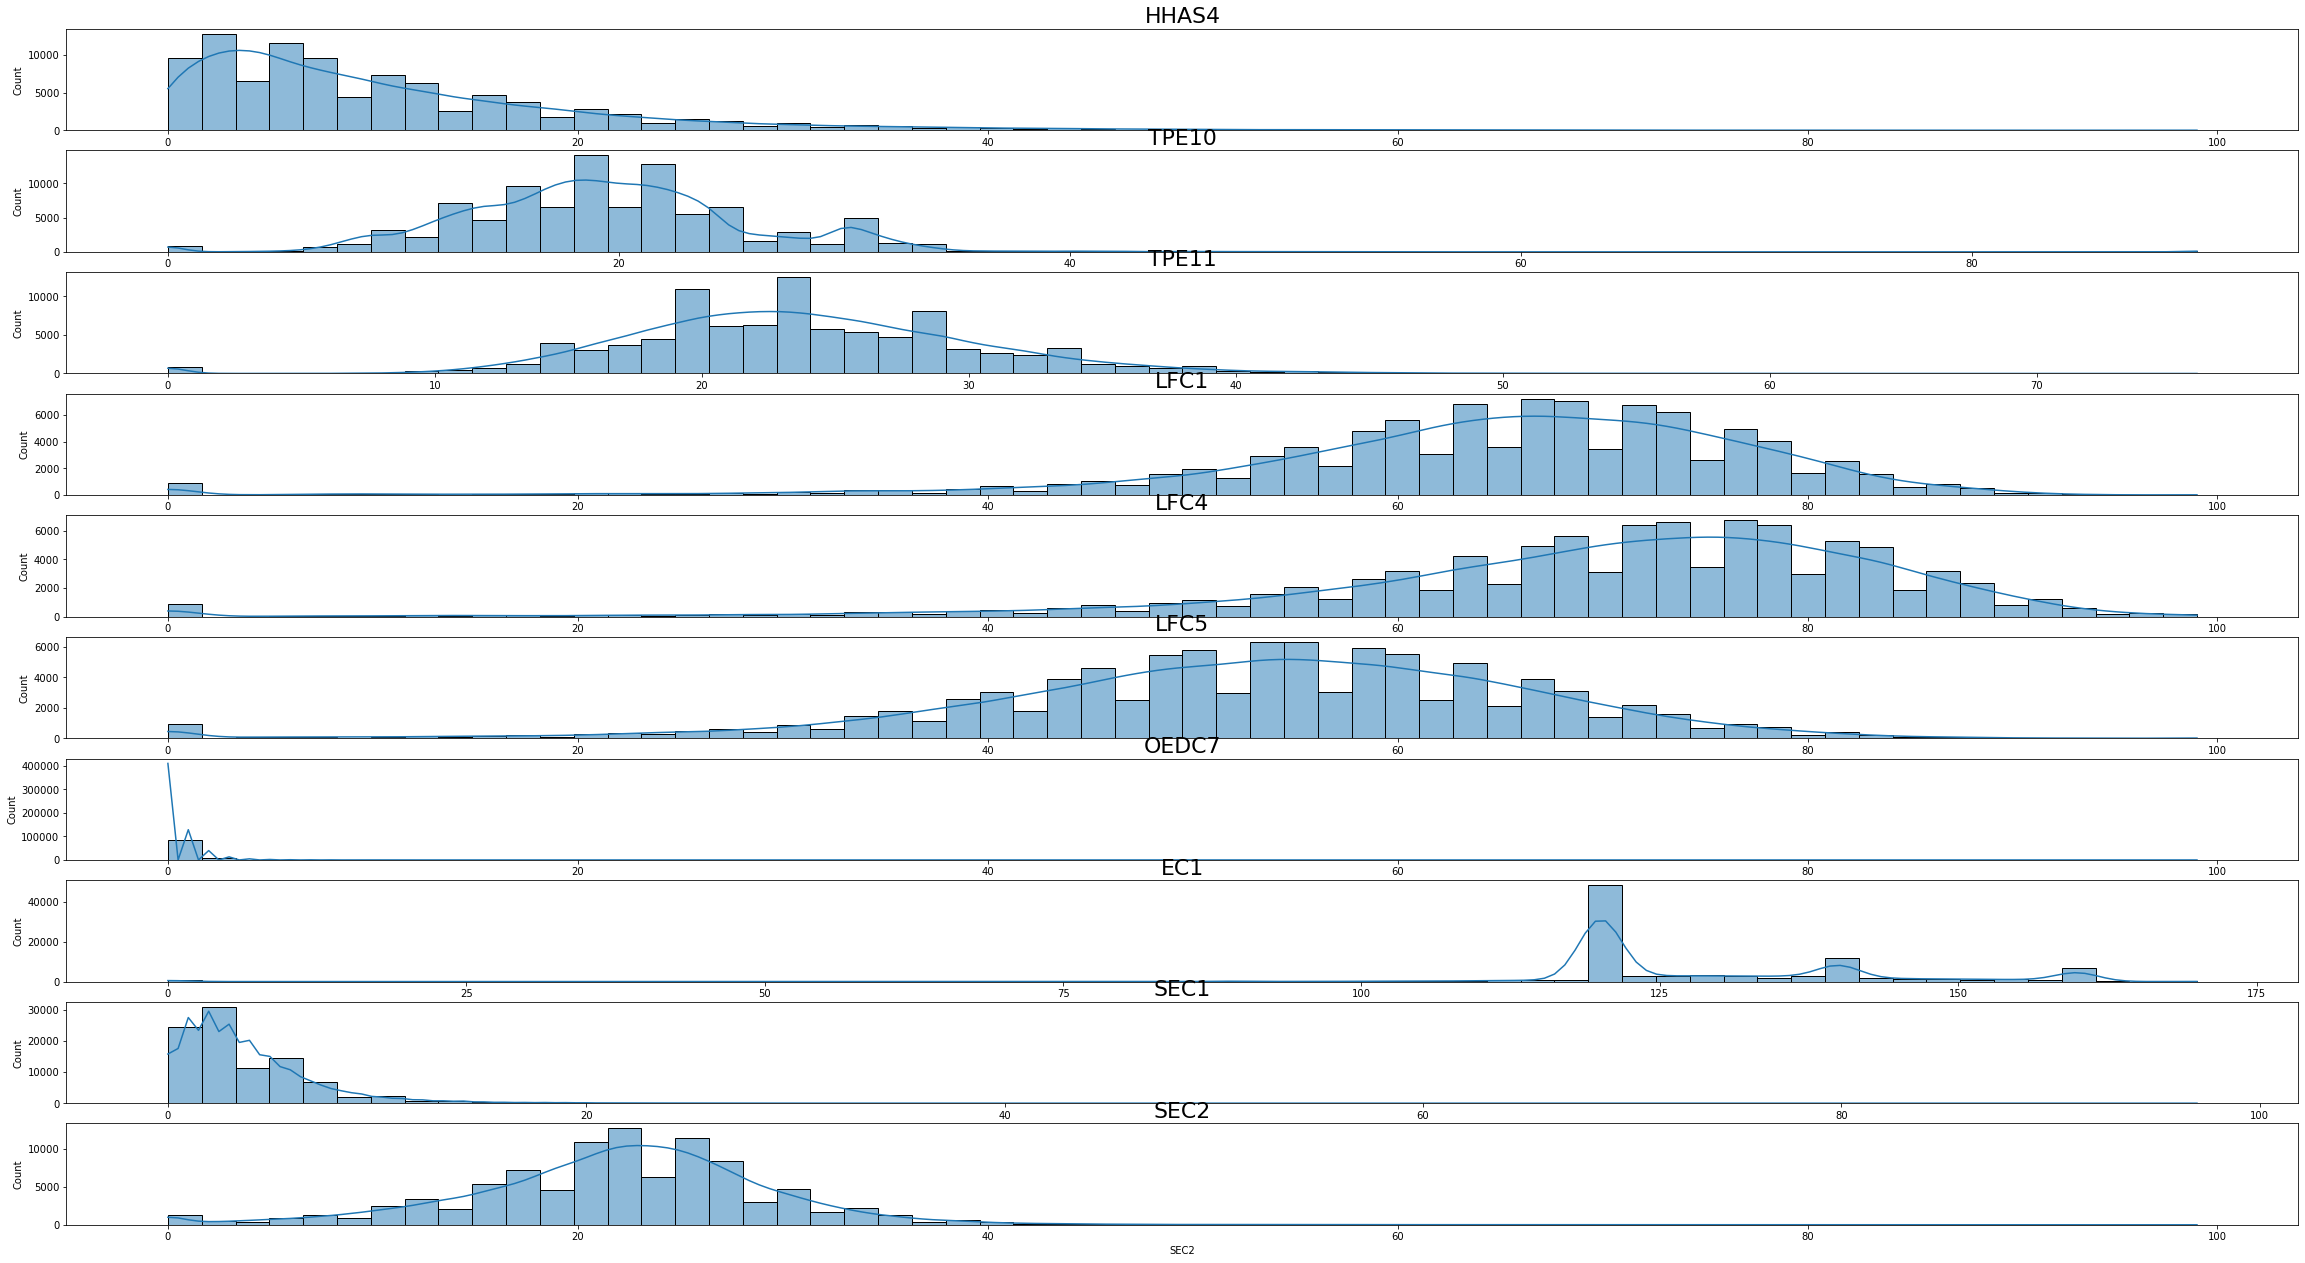

In [30]:
# Plot distributions of these ethnicity variables.
fig, axs = plt.subplots(nrows = len(temp_census[2]), figsize = (40, 22), sharex= False)

for i, l in enumerate(temp_census[2]):
    sns.histplot(data=donors_df[l],bins= 60,kde=True, ax = axs[i])
    axs[i].set_title(l, size = 22)
plt.show()

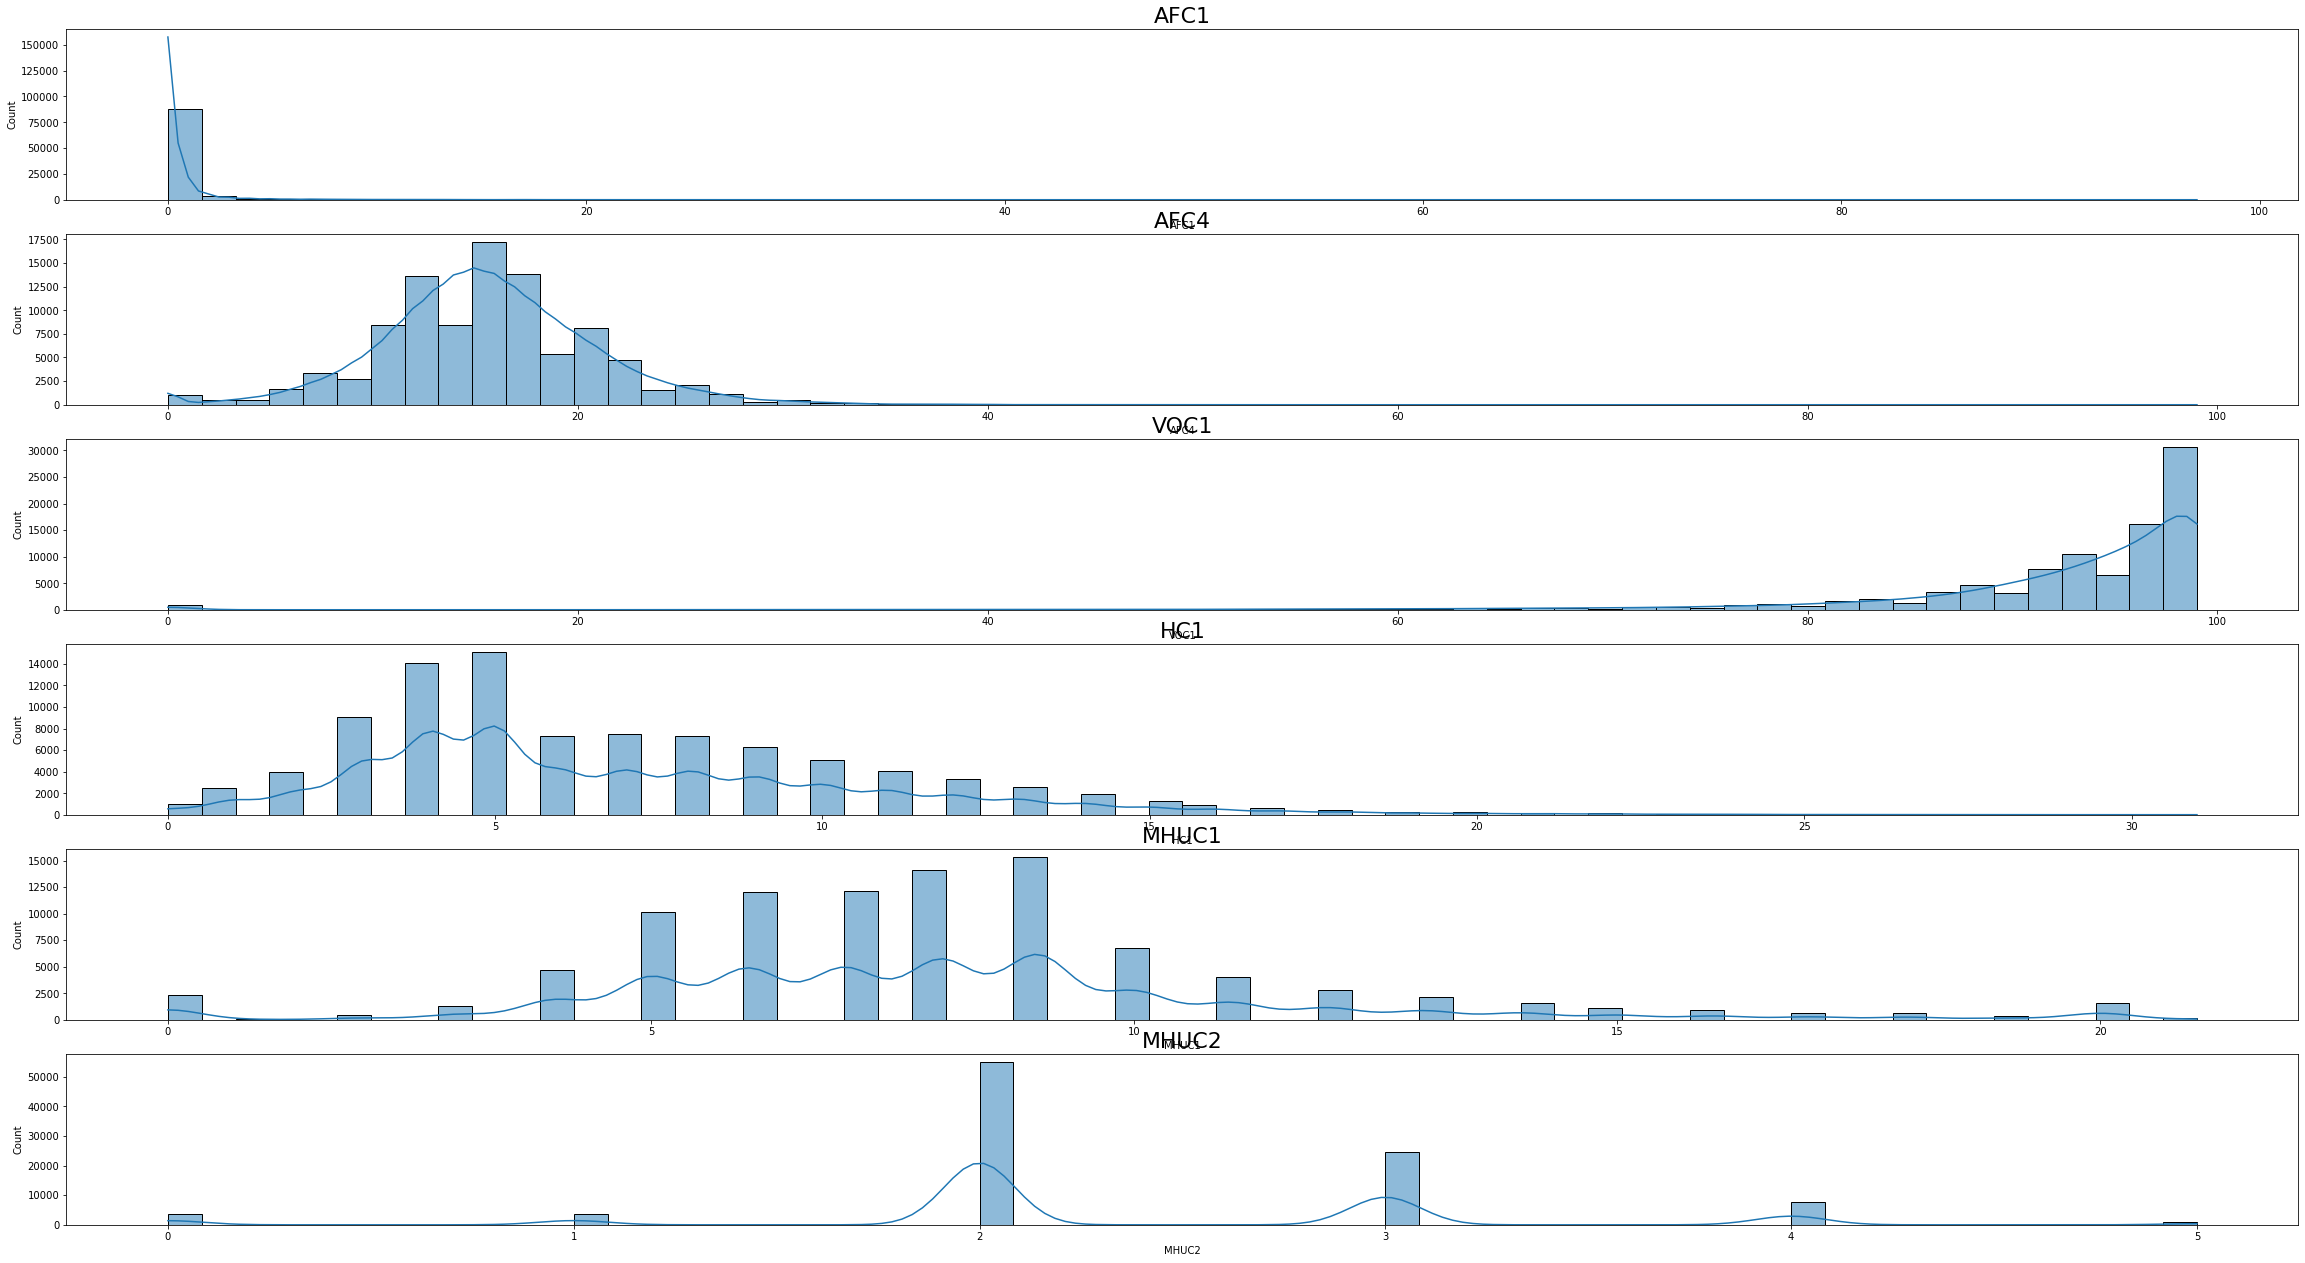

In [31]:
# Plot distributions of these ethnicity variables.
fig, axs = plt.subplots(nrows = len(temp_census[3]), figsize = (40, 22), sharex= False)

for i, l in enumerate(temp_census[3]):
    sns.histplot(data=donors_df[l],bins= 60,kde=True, ax = axs[i])
    axs[i].set_title(l, size = 22)
plt.show()

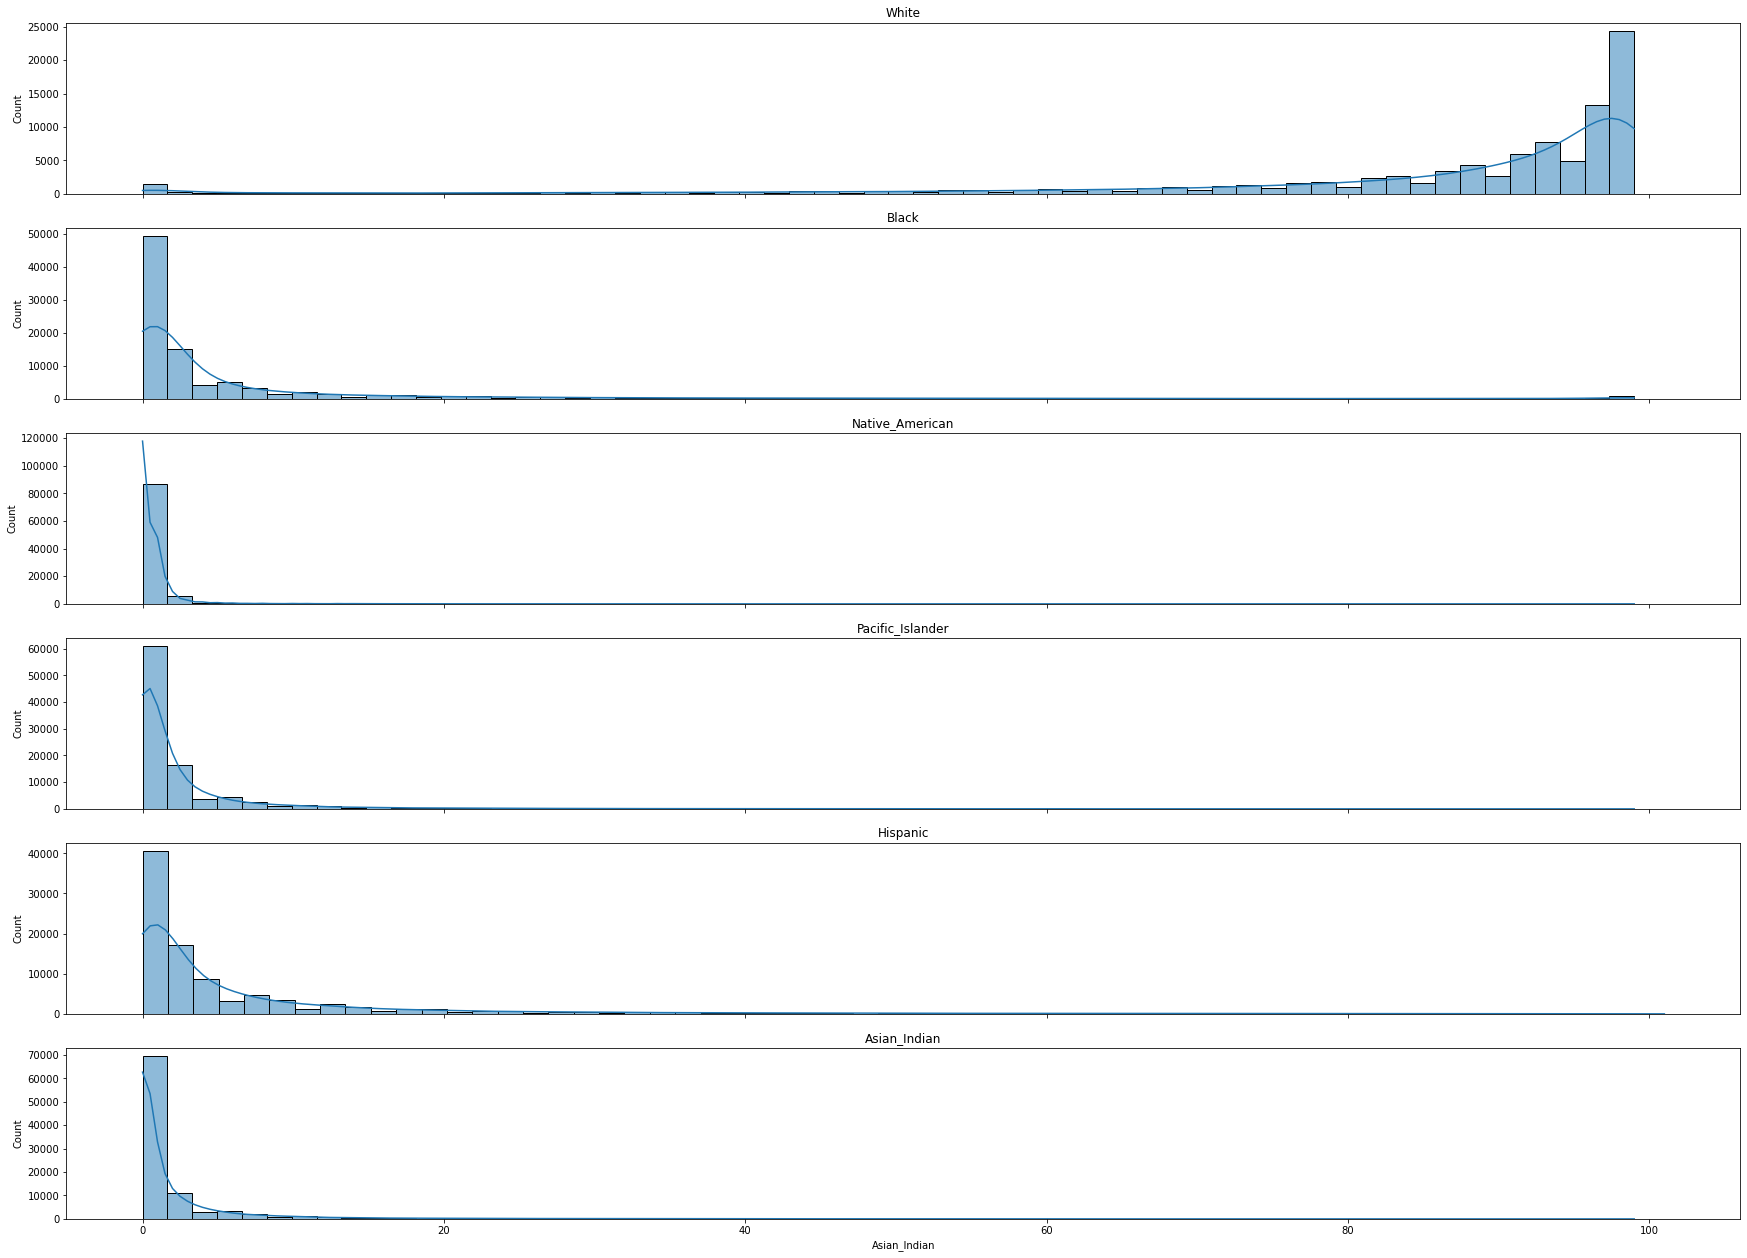

In [32]:
# Also check ethnicity data.
eth_df_columns = ["White", "Black", "Native_American", "Pacific_Islander", "Hispanic", "Asian_Indian"]

# Some can be merged:
sum_asian = donors_df["ETH6"]+donors_df["ETH7"]+donors_df["ETH8"]+donors_df["ETH9"]+donors_df["ETH10"]+donors_df["ETH11"]
sum_hisp = donors_df["ETH13"]+donors_df["ETH14"]+donors_df["ETH15"]+donors_df["ETH16"]

eth_dict = {"White": donors_df["ETH1"], "Black": donors_df["ETH2"], "Native_American": donors_df["ETH3"],\
            "Pacific_Islander": donors_df["ETH4"], "Hispanic": sum_hisp, "Asian_Indian": sum_asian}

eth_df = pd.DataFrame(eth_dict)

# Plot distributions of these ethnicity variables.
fig, axs = plt.subplots(nrows = len(eth_df_columns), figsize = (30, 22),sharex=True)

for i, l in enumerate(eth_df_columns):
    sns.histplot(data=eth_df[l],bins= 60,kde=True,ax = axs[i])
    axs[i].set_title(l)
plt.show()

The implication from this distribution is that we have need of only ETH1.

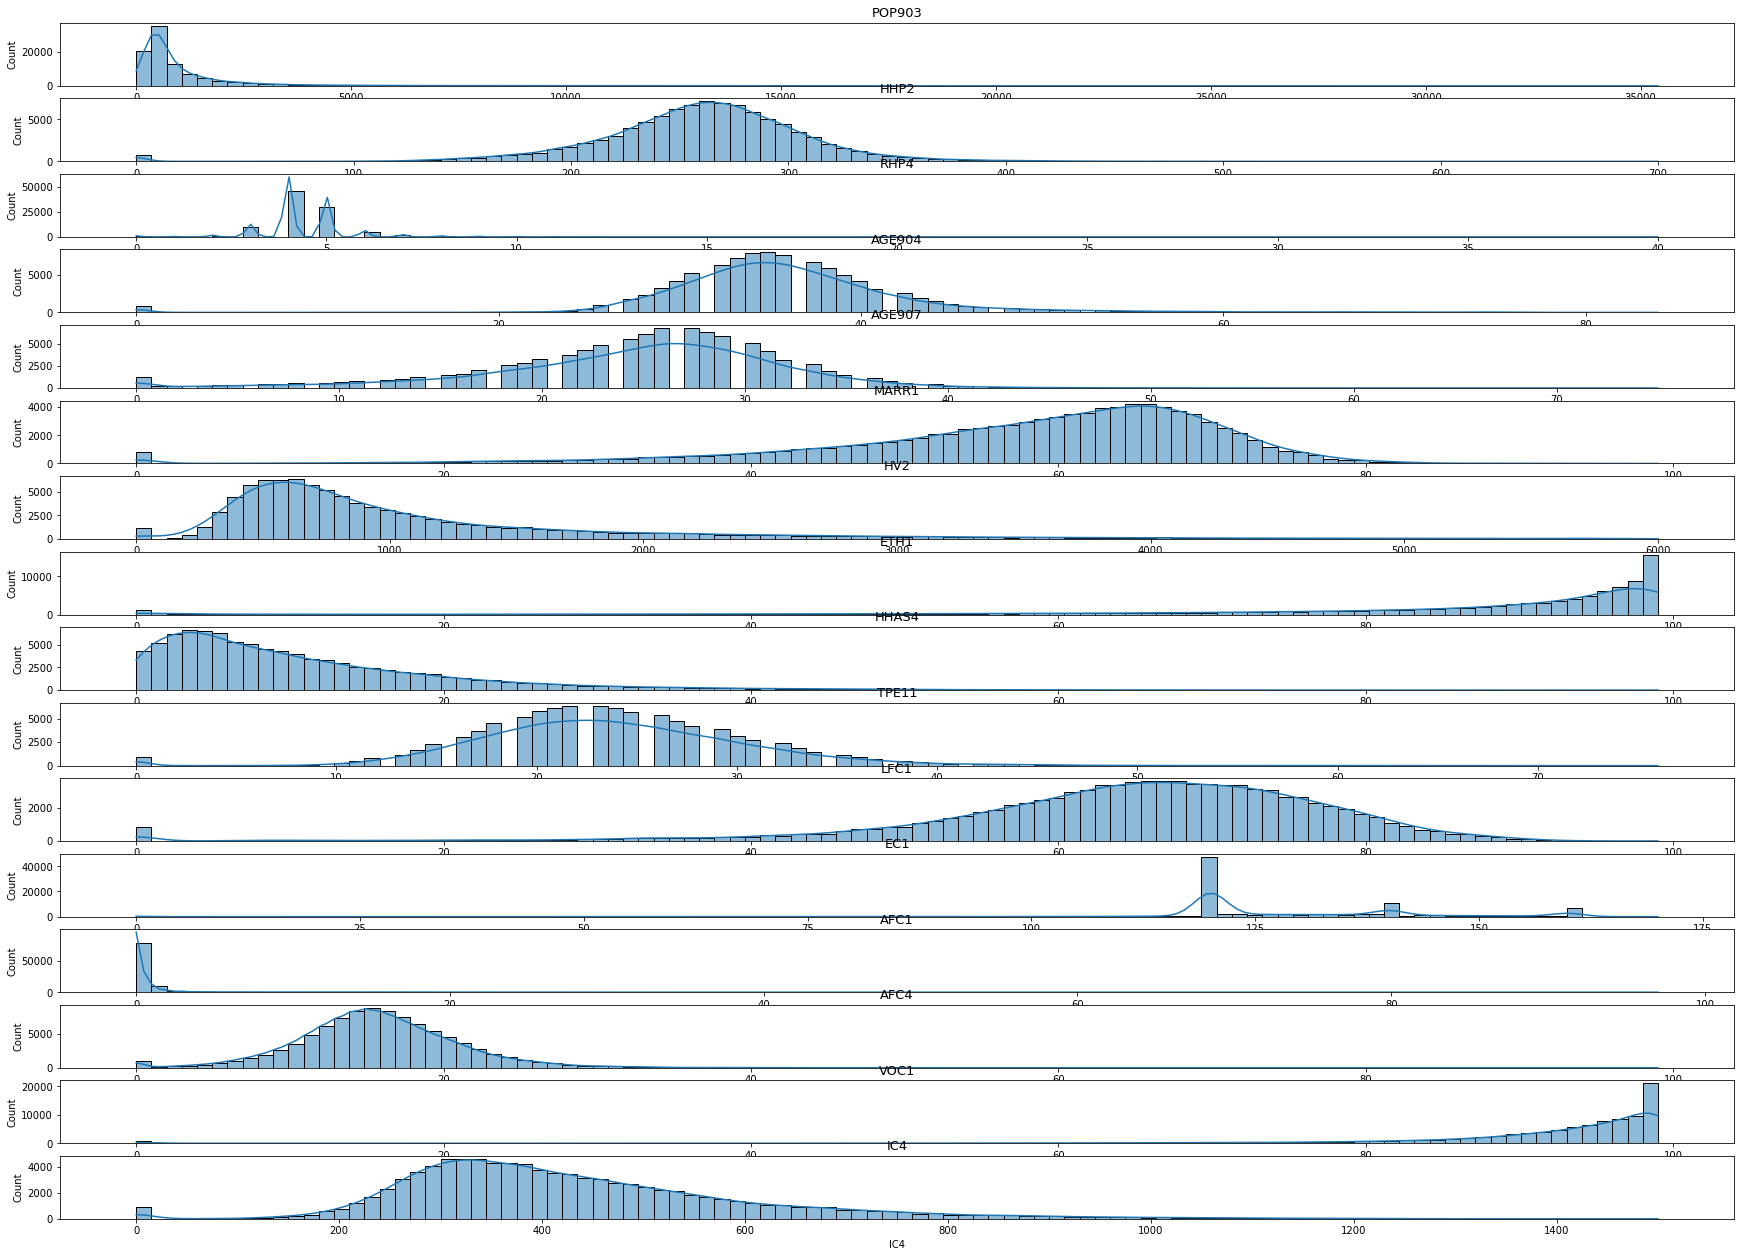

In [33]:
# Declare census data to use.
census_u = ["POP903","HHP2","RHP4","AGE904","AGE907","MARR1","HV2",\
            "ETH1","HHAS4","TPE11","LFC1","EC1","AFC1","AFC4","VOC1","IC4"]

In [34]:
# Fix the values of HHP2 and EC1. The if check is there in case someone runs this twice without realizing it (like i did once).
if (donors_df.loc[:,"HHP2"]>100).any():
    hhp2 = donors_df.loc[:,"HHP2"].apply(lambda x : (x/100))
    donors_df["HHP2"] = hhp2

if (donors_df.loc[:,"EC1"]>100).any():
    ec1 = donors_df.loc[:,"EC1"].apply(lambda x : (x/10))
    donors_df["EC1"] = ec1
    
donors_df.loc[:,["HHP2","EC1"]].head(4)

,HHP2,EC1
0,2.76,12.0
1,3.60,16.0
2,2.54,12.0
3,2.83,12.0


In [36]:
# Investigate irregularities.
# 0 people neighborhoods are a sign of missing census data, not of missing donation data. We first grab the index of all the features that cannot be 0, but are.
pop_0 = donors_df[census_u].iloc[np.where(
    (donors_df["POP903"]==0) & (donors_df["HHP2"]==0) &
    (donors_df["RHP4"]==0) & (donors_df["AGE904"]==0) &
    (donors_df["HV2"]==0) & (donors_df["TPE11"]==0) &
    (donors_df["LFC1"]==0) & (donors_df["EC1"]==0) &
    (donors_df["IC4"]==0)
)[0]].index

In [37]:
# Before immediately replacing census values with medians / averages, consider that as the data here relates to neighborhoods, we may be able to fill \
# missing values with data from records with the same zip codes, if available. However, these do not go to the neighborhood level, and this method would only
# allow us to fill about 100 records, a negligible number for this dataset. 
# As such, we opt to fill these values with the medians for the dataset (which would represent the median of the US as a whole, making them non-representativa at best instead of skewing the values as outliers).

# Because all 0s in these are surely wrong (including the other variables in census_u), we replace them with NaNs.
donors_df.loc[pop_0,census_u] = donors_df.loc[pop_0,census_u].replace(0,np.NaN)

In [38]:
# Fix all "impossible" zeroes.
to_fix = ["POP903", "HHP2", "RHP4","AGE904","HV2","TPE11","LFC1","EC1","IC4"]
donors_df.loc[:,to_fix] = donors_df.loc[:,to_fix].replace(0,np.NaN)

In [39]:
# For AGE907 AKA presence of children, any positive indication of children existing means the value cannot be zero.
temp = ["CHIL1","CHIL2","CHIL3","CHILC1","CHILC2","CHILC3","CHILC4","CHILC5"]

# This will be the index of impossible zeroes for this category.
to_fix = np.where(
    ( (donors_df[temp]>0).any(axis=1) ) & (donors_df["AGE907"]==0) )[0]

donors_df["AGE907"].iloc[to_fix].replace(0, np.NaN, inplace = True)

In [40]:
# For VOC1, check other VOCs. If anyone has more than 2 vehicles, then they must have one, etc.
temp = ["VOC2","VOC3"]

# This will be the index of impossible zeroes for this category.
to_fix = np.where(
    ( (donors_df[temp]>0).any(axis=1) ) & (donors_df["VOC1"]==0) )[0]

donors_df["VOC1"].iloc[to_fix].replace(0, np.NaN, inplace = True)

Series([], Name: VOC1, dtype: float64)

In [41]:
# For MARR1, ETH1, HHAS4, while there is no direct way of knowing the 0s are genuine, we can infer that if the row has many NaNs then the 0 is also a missing value.
# The more likely rows for this are where they are all 0.
rows = np.where(
(donors_df["MARR1"]==0) & (donors_df["ETH1"]==0) & (donors_df["HHAS4"]==0) )[0]

to_fix = (donors_df[census_u].iloc[rows].isna().sum(axis=1)>(len(census_u)/3)).index

donors_df.loc[to_fix,["MARR1","ETH1","HHAS4"]] = np.NaN

In [42]:
# Finally, fill all missing values with the median of their column.
donors_df.loc[:,census_u] = donors_df.loc[:,census_u].fillna(donors_df.loc[:,census_u].median())

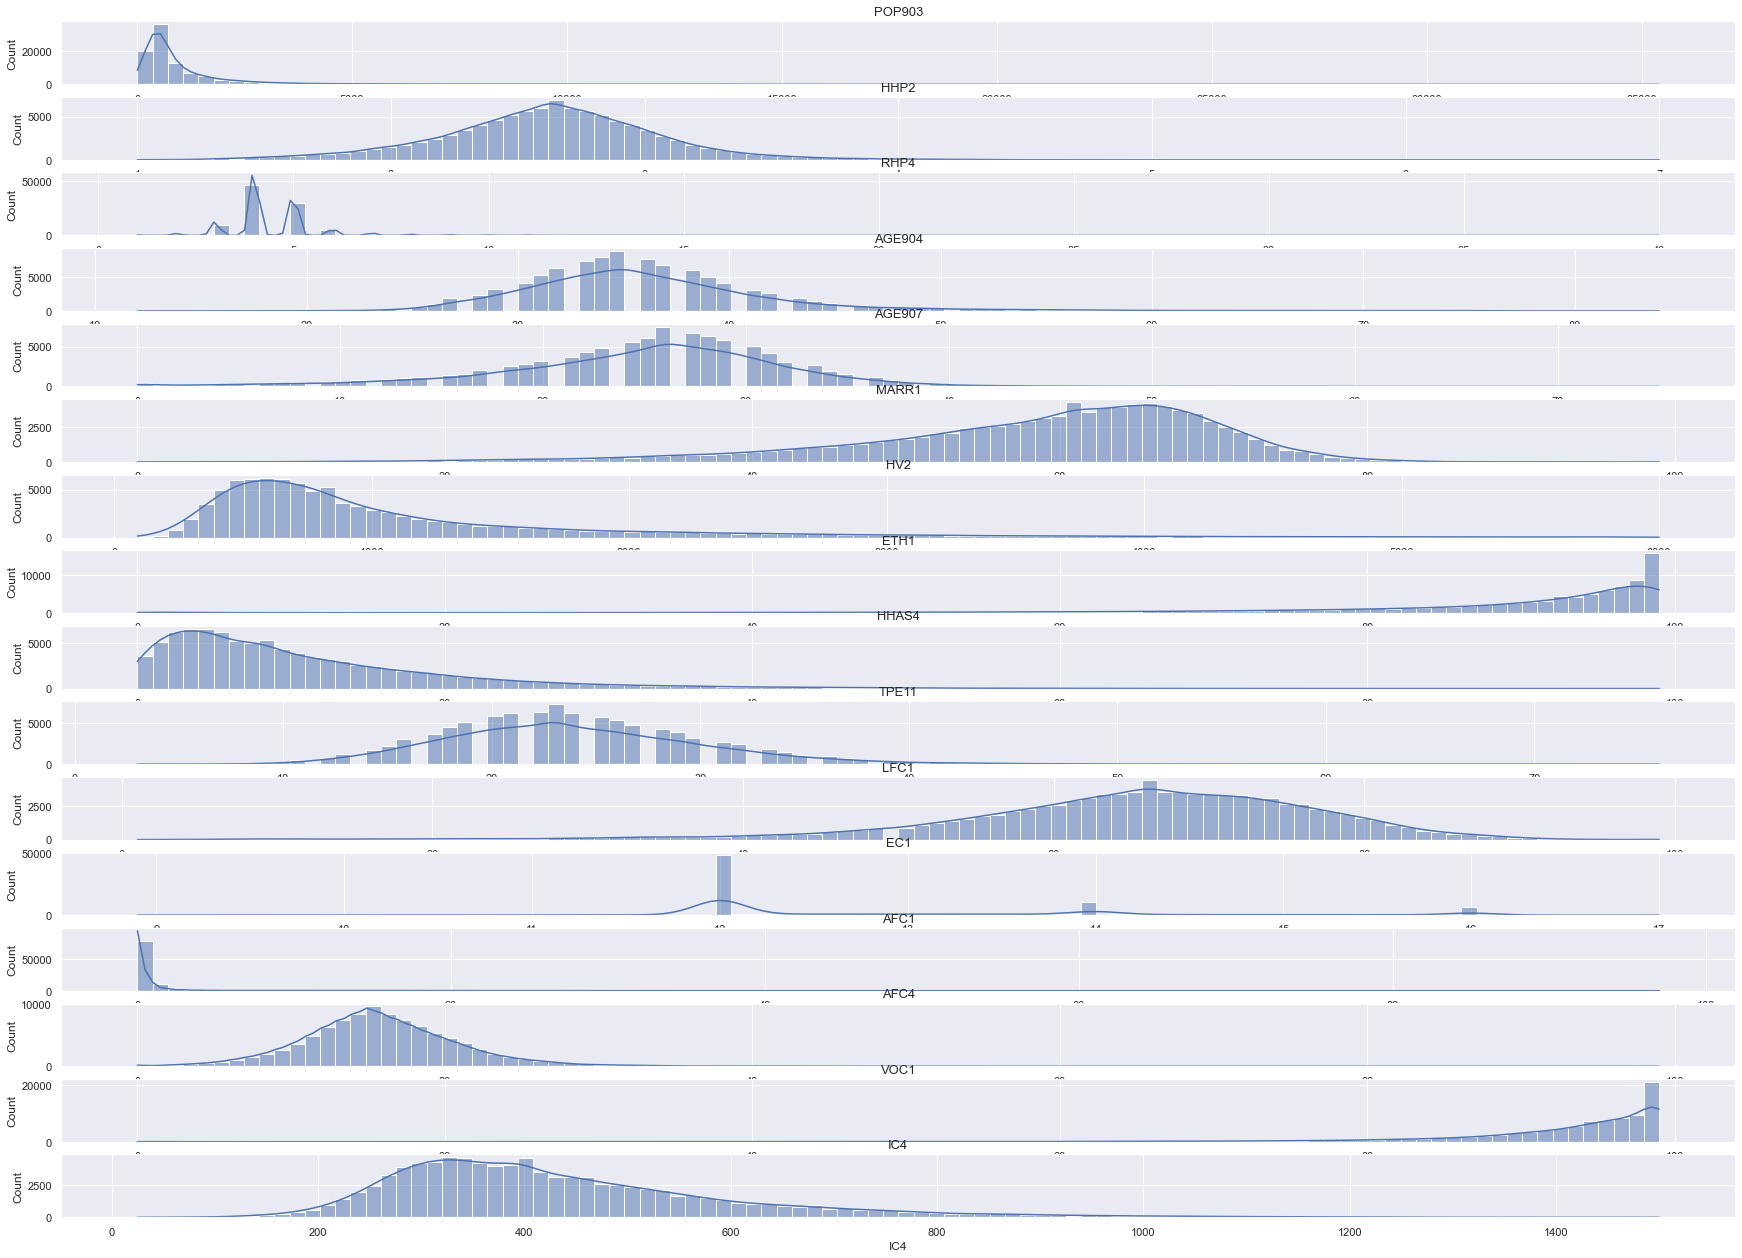

In [97]:
# Check the distribution for all census_u variables.
fig, axs = plt.subplots(nrows = len(census_u), figsize = (30, 22), sharex= False)

for i, l in enumerate(census_u):
    sns.histplot(data=donors_df[l],bins= 100,kde=True, ax = axs[i])
    axs[i].set_title(l, size = 13)
plt.show()

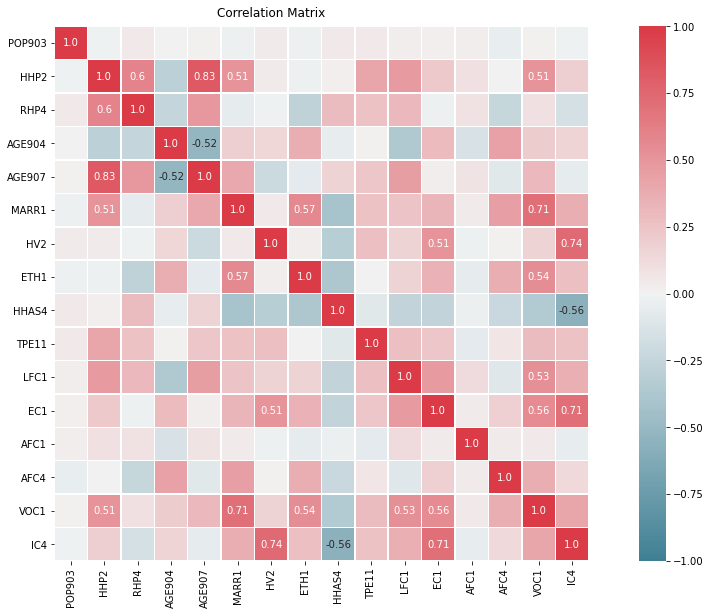

In [35]:
# Visualize the new set of metric features.
fig = plt.figure(figsize=(18,9))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(donors_df[census_u].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=12)
plt.show()

In [98]:
# Check for other outliers.

# Manual filters first.

# IQR method.
q25 = donors_df.quantile(.25)
q75 = donors_df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for feat in census_u:
    llim = lower_lim[feat]
    ulim = upper_lim[feat]
    filters2.append(donors_df[feat].between(llim, ulim, inclusive=True))

filters2 = pd.Series(np.all(filters2, 0))
df_2 = donors_df[filters2]

remove_nr = np.round(df_2.shape[0] / donors_df.shape[0], 4)
print('Removing outliers with the IQR method from this group would remove {}% of the data.'.format(np.round((1-remove_nr)*100),3))

Removing outliers with the IQR method from this group would remove 50.0% of the data.


If 50% of the data would be removed if we were to eliminate outliers (and this is after fixing inconsistent data, zeroes, and some other detectable issues), the usefulness of this group of variables needs to be called into question.

In [44]:
# Extend fields to keep after this exploration.
fields_to_keep.extend(census_u)

---

### **Exploring Household Variables** <a name="Household"></a>

In [45]:
donors_df[household].head()

,PVASTATE,HOMEOWNR,GENDER,NUMCHLD,INCOME,WEALTH1,DOMAIN
0,NaN,NaN,F,NaN,NaN,NaN,T2
1,NaN,H,M,1.0,6.0,9.0,S1
2,NaN,U,M,NaN,3.0,1.0,R2
3,NaN,U,F,NaN,1.0,4.0,R2
4,NaN,H,F,1.0,3.0,2.0,S2


In [46]:
donors_df[household].describe()

,NUMCHLD,INCOME,WEALTH1
count,12386.000000,74126.000000,50680.000000
mean,1.527773,3.886248,5.345699
std,0.806861,1.854960,2.742490
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,3.000000
50%,1.000000,4.000000,6.000000
75%,2.000000,5.000000,8.000000
max,7.000000,7.000000,9.000000


In [47]:
for column in donors_df[household].columns:
    print(donors_df[column].value_counts())
    print("Missing Values: {}, which is {:.2f}% of the total. \n".format(donors_df[column].isna().sum(),(donors_df[column].isna().sum()*100/donors_df.shape[0])))

P    1453
E       5
Name: PVASTATE, dtype: int64
Missing Values: 93954, which is 98.47% of the total. 

H    52354
U    20830
Name: HOMEOWNR, dtype: int64
Missing Values: 22228, which is 23.30% of the total. 

F    51277
M    39094
U     1715
J      365
A        2
C        2
Name: GENDER, dtype: int64
Missing Values: 2957, which is 3.10% of the total. 

1.0    7792
2.0    3110
3.0    1101
4.0     316
5.0      59
6.0       7
7.0       1
Name: NUMCHLD, dtype: int64
Missing Values: 83026, which is 87.02% of the total. 

5.0    15451
2.0    13114
4.0    12732
1.0     9022
3.0     8558
6.0     7778
7.0     7471
Name: INCOME, dtype: int64
Missing Values: 21286, which is 22.31% of the total. 

9.0    7585
8.0    6793
7.0    6198
6.0    5825
5.0    5280
4.0    4810
3.0    4237
2.0    4085
1.0    3454
0.0    2413
Name: WEALTH1, dtype: int64
Missing Values: 44732, which is 46.88% of the total. 

R2    13623
T2    12369
S1    11503
S2     8530
C2     8264
C1     6145
C3     5280
T1     4982
R3   

PVAState means too much of the population is not served by a PVA chapter. Marginally useful, e.g. all records from these states are "good" donors. Delete.

HOMEOWNR is also a very poor variable. It has a lot of missing records and it is *not* a binary variable. 

GENDER is fairly complete, and has a class for unknown gender, so we can fill missing values with that.

NUMCHLD is available for only about 10% of the records. Given the Min, it's probably safe to assume a NAN = 0. This can be checked against some census data and "presence of children in household".

INCOME is available for 74k records, and wealth for 50k. For these cases, we will need to find a way to fill missing values if we want to use them. They may be regressable based on other variables.

DOMAIN is the most complete variable, but needs to be decomposed as well.

In [48]:
# Preprocess Gender.
# I dont see any other variable that can give an indication of gender, so I would say to make any missing value be unknown.
donors_df["GENDER"].fillna("U",inplace=True)

In [49]:
# Preprocess NUMCHLD.
child = ["NUMCHLD","CHILD03","CHILD07","CHILD12","CHILD18"]

# Intersects the indexes of the records where numchild is unknown but there is a presence of a child, aged whatever.
idx = np.intersect1d(np.where(donors_df["NUMCHLD"].isna()), np.where(donors_df[child[1:]].isna()==False)[0])
print(idx.shape)

# Now we need to convert letters to their respective numbers, and then replace NUMCHLD in the same row. F or M = 1, B equals 2. 
# There is a particular case where a B may be more than two, but this is already such a small subset the effect should be negligible on the data.

donors_df[child].replace({"B":2,"F":1,"M":1}, inplace=True)

# As we only want to replace the idx that we set above, create an auxiliary column with the sum of the previous rows (w/o numchld).
# All these .locs are here to avoid "setting with copy warning". Alas, it still seems to happen, so.
donors_df.loc[:,"SUM"] = donors_df.loc[:,child].iloc[:,1:].sum(axis=1)
donors_df.loc[:,"NUMCHLD"].iloc[idx] = donors_df.loc[:,"SUM"].iloc[idx]
donors_df.drop(columns="SUM")
donors_df.loc[:,"NUMCHLD"].fillna(value=0,inplace=True)
donors_df[child].head()


(1544,)


C:\Users\Tiago\.conda\envs\datamining\lib\site-packages\pandas\core\frame.py:4385: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
C:\Users\Tiago\.conda\envs\datamining\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,NUMCHLD,CHILD03,CHILD07,CHILD12,CHILD18
0,0.0,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN,M
2,0.0,NaN,NaN,NaN,NaN
3,0.0,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,NaN


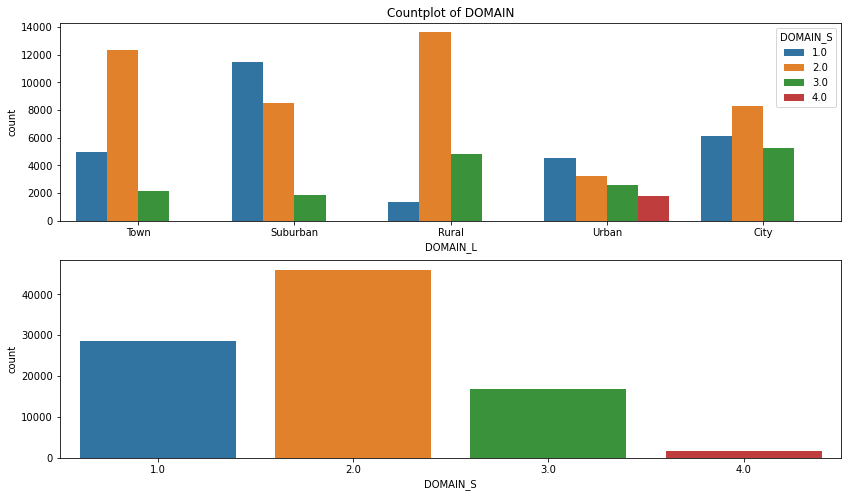

In [50]:
# Decompose DOMAIN.
# 1st byte: Urbanicity Level (Urban, City, Suburban, Town, Rural)
# 2nd byte: Socio-economic Status (1 is highest. Urban has 4 levels.)

domain_df = donors_df["DOMAIN"].str.split(r"",expand=True).drop(columns=[0,3]).rename(columns={1:"DOMAIN_L",2:"DOMAIN_S"}).replace(
    {"T":"Town","U":"Urban","C":"City","S":"Suburban","R":"Rural"})
domain_df["DOMAIN_S"] = domain_df["DOMAIN_S"].astype(float)


plt.subplots(nrows=2,figsize=(14,8))
plt.subplot(211)
ax = sns.countplot(data=domain_df,x="DOMAIN_L",hue="DOMAIN_S")
ax.set_title("Countplot of DOMAIN")
plt.subplot(212)
ax1 = sns.countplot(data=domain_df,x="DOMAIN_S")
plt.show()

In [51]:
# Deal with DOMAIN missing values.
# As it is 2.3% of the data, and it is fairly distributed, it makes more sense to use a specific fill method for it. This way the data will be distributed, without generating too much noise.
domain_df = domain_df.fillna(method="backfill")

In [52]:
# Add these columns to donors_df, and to fields_to_keep.
for field in ["DOMAIN_L","DOMAIN_S"]:
    donors_df[field] = domain_df[field]

fields_to_keep.extend(["DOMAIN_L","DOMAIN_S"])

#### - Wealth -

In [53]:
# Preprocess INCOME and WEALTH.

# Tiago: I just want to note that using these three features in conjunction is essentially 
# engineering a new feature that acts as a singular representative of a household's wealth.
# also, quick reminder DOMAIN_S is in reverse order: the lower the number, the richer.

# Census Data also includes a number of variables relating to the neighborhood which can be very helpful. They also don't have missing values.
richness = ["INCOME","WEALTH1","WEALTH2","DOMAIN_S"]
donors_df[richness].head()

,INCOME,WEALTH1,WEALTH2,DOMAIN_S
0,NaN,NaN,5.0,2.0
1,6.0,9.0,9.0,1.0
2,3.0,1.0,1.0,2.0
3,1.0,4.0,0.0,2.0
4,3.0,2.0,NaN,2.0


In [54]:
# Visualize countplots for the features in richness.
#fig, ax = plt.subplots(nrows=len(richness),figsize=(15,20))
#sns.set_theme()
#
#for i,column in enumerate(donors_df[richness].columns):
#    sns.countplot(x=column,data=donors_df[richness],ax=ax[i])

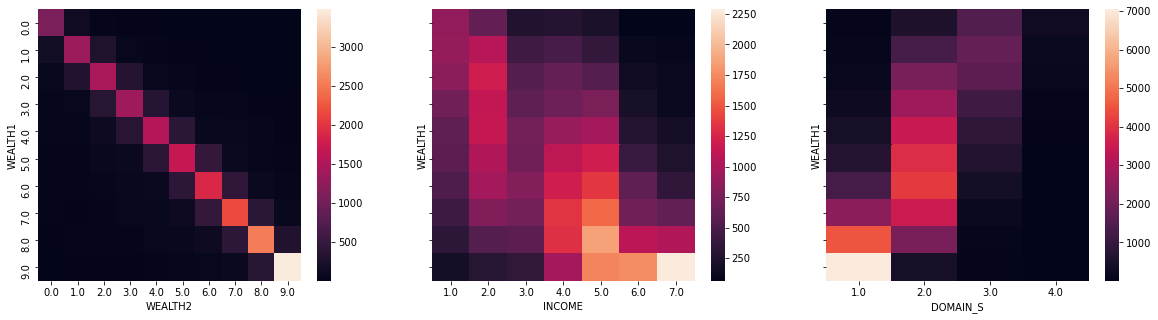

In [55]:
fig, ax = plt.subplots(ncols=3,figsize=(20,5),sharey=True)

sns.heatmap(donors_df.groupby("WEALTH1")["WEALTH2"].value_counts().unstack(),ax=ax[0])
sns.heatmap(donors_df.groupby("WEALTH1")["INCOME"].value_counts().unstack(),ax=ax[1])
sns.heatmap(donors_df.groupby("WEALTH1")["DOMAIN_S"].value_counts().unstack(),ax=ax[2])
plt.show()

# I also tried with the following features, with no good results:
# NUMCHLD, MAJOR, RFA_2A

In [56]:
for feat in richness:
    print("{} missing values: {} of {}.".format(feat,donors_df[feat].isna().sum(),donors_df.shape[0]))

INCOME missing values: 21286 of 95412.
WEALTH1 missing values: 44732 of 95412.
WEALTH2 missing values: 43823 of 95412.
DOMAIN_S missing values: 0 of 95412.


In [57]:
# Identify and store the index of the records with no data for any of the richness features.
temp_series = donors_df[richness].sum(axis=1)
na_rich_idx = temp_series[temp_series==0].index

# Identify and store the index of the records with complete data for all richness features.
full_rich_idx = np.where(donors_df[richness].isna().any(axis=1)==False)[0]

In [58]:
## Functions for the split train test of dt_wealth.

def avg_score(model):
    # apply kfold
    kf = KFold(n_splits=10)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    for train_index, test_index in kf.split(X):
        # get the indexes of the observations assigned for each partition
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # start counting time
        begin = time.perf_counter()
        # fit the model to the data
        model.fit(X_train, y_train)
        # finish counting time
        end = time.perf_counter()
        # check the mean accuracy for the train
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_test,y_test)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end-begin)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_test) + '+/-' + str(std_test)

def show_results(df, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for arg in args:
        # obtain the results provided by avg_score
        time, avg_train, avg_test = avg_score(arg)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test
        count+=1
    return df

I tried a DT with gridsearch to find out if we could classify Wealth1. The most important feature for this, with a 0.649 accuracy, was WEALTH2.

In [59]:
# Use a Decision Tree to classify Wealth1. 
X = donors_df[richness].iloc[full_rich_idx,:].drop(columns="WEALTH1")
y = donors_df["WEALTH1"].iloc[full_rich_idx]

dt_wealth = tree.DecisionTreeClassifier(class_weight= None,
 criterion= 'gini',
 max_depth= 6,
 min_samples_leaf= 3,
 min_samples_split= 10,
 splitter= 'best'
)

temp_df = pd.DataFrame(columns = ['Time','Train','Test'], index = ["Decision Tree"])
show_results(temp_df,dt_wealth)

,Time,Train,Test
Decision Tree,0.026+/-0.0,0.649+/-0.0,0.648+/-0.01


In [60]:
dt_wealth.feature_importances_

array([0.00440273, 0.96562375, 0.02997352])

In [61]:
# Identify index with Wealth2 but not Wealth1 values.
w2_idx = np.where(
    (donors_df["WEALTH1"].isna()) & (donors_df["WEALTH2"].isna()==False)
)[0]

donors_df[richness].iloc[w2_idx,:]

# There's over 22k observations where we have wealth2 and other metrics, but not wealth1. But this can be used to fill Wealth1, as Wealth2 has such a high correlation with Wealth1.
# We can do almost a manual decision tree. If wealth2 is not available, we use DOMAIN_S because DOMAIN_S=1 is highly correlated with wealth2 and therefore wealth1.

,INCOME,WEALTH1,WEALTH2,DOMAIN_S
0,NaN,NaN,5.0,2.0
9,NaN,NaN,9.0,1.0
13,NaN,NaN,6.0,2.0
23,NaN,NaN,2.0,1.0
38,6.0,NaN,6.0,2.0
...,...,...,...,...
95398,NaN,NaN,9.0,1.0
95399,2.0,NaN,1.0,2.0
95403,4.0,NaN,5.0,2.0
95404,1.0,NaN,3.0,2.0


In [62]:
# Create a new feature, WEALTH (capturing all measures of wealth).
donors_df["WEALTH"] = donors_df["WEALTH1"]

# Now fill the missing values with values from wealth2, when possible.
print("Missing values before setting Wealth2: {} of {}.".format(donors_df["WEALTH"].isna().sum(),donors_df.shape[0]))
donors_df["WEALTH"].iloc[w2_idx] = donors_df["WEALTH2"].iloc[w2_idx]

# How many values are still missing.
print("Amount of missing values of {}: {} of {}.".format("WEALTH",donors_df["WEALTH"].isna().sum(),donors_df.shape[0]))

Missing values before setting Wealth2: 44732 of 95412.
Amount of missing values of WEALTH: 21843 of 95412.


C:\Users\Tiago\.conda\envs\datamining\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [63]:
# Use another Decision Tree to classify Wealth based on Income and Domain_S. Used gridsearh to find the best parameter space.

# Grab the needed index.
temp_idx = np.where(
    (donors_df["WEALTH"].isna()==False) & (donors_df["INCOME"].isna()==False) & (donors_df["DOMAIN_S"].isna()==False)
)[0]

X = donors_df[["INCOME","DOMAIN_S"]].iloc[temp_idx,:]
y = donors_df["WEALTH"].iloc[temp_idx]

dt_wealth = tree.DecisionTreeClassifier(
    class_weight= None,
    criterion= 'entropy',
    max_depth= 6,
    min_samples_leaf= 200,
    min_samples_split= 100,
    splitter= 'random'
)

temp_df = pd.DataFrame(columns = ['Time','Train','Test'], index = ["Decision Tree"])
show_results(temp_df,dt_wealth)

,Time,Train,Test
Decision Tree,0.027+/-0.0,0.254+/-0.01,0.253+/-0.01


The accuracy is really low for a combination of DOMAIN_S and INCOME, so using it instead of some kind of central tendency measure might be bad. If we used a central tendency measure, we'd be getting an even lower percentage of correct classifications. We have about 11k observations without Wealth1 and both INCOME and DOMAIN_S. But we have another option, which is worse than Wealth2 but better than Income / Domain_S. The IC values in the census data from 2010.

In [64]:
#fig, ax = plt.subplots(nrows=23,figsize=(10,80))
#
#ic_census = ["IC1","IC2","IC3","IC4","IC5","IC6","IC7","IC8","IC9","IC10","IC11","IC12","IC13","IC14","IC15","IC16","IC17","IC18","IC19","IC20","IC21","IC22","IC23"]
#
#for i,ic in enumerate(ic_census):
#    sns.heatmap(donors_df.groupby("WEALTH")[ic].value_counts().unstack(),ax=ax[i])
#plt.show()
#
# This is commented out because it takes a while to run. Also needs to be improved in terms of readiability.

In [65]:
# Use another Decision Tree to classify Wealth based on IC1 to 4. Used gridsearh to find the best parameter space.
# Also use KNN.
# I tried with other features in the IC space, but these 4 were the most relevant.

# Grab the needed index.
temp_idx = np.where(
    (donors_df["WEALTH"].isna()==False))[0]

X = donors_df[["IC1","IC2","IC3","IC4"]].iloc[temp_idx,:]
y = donors_df["WEALTH"].iloc[temp_idx]

#dt_wealth = tree.DecisionTreeClassifier(
#    class_weight= None,
#    criterion= 'gini',
#    max_depth= 200,
#    min_samples_split= 50,
#    splitter= 'best'
#) 

# KNN gets a better score but it can be really slow to run, especially with a higher amount of variables. 
knn =  KNeighborsClassifier().fit(X=X,y=y)

temp_df = pd.DataFrame(columns = ['Time','Train','Test'], index = ["knn"])
show_results(temp_df,knn)

,Time,Train,Test
knn,0.278+/-0.01,0.556+/-0.0,0.373+/-0.01


KNN has an accuracy of about 0.35, which is marginally better at classifying Wealth. We will use this to fill wealth.

In [66]:
# Fill the remaining values of Wealth.
temp_idx = np.where((donors_df["WEALTH"].isna()))[0]

donors_df["WEALTH"].iloc[temp_idx] = knn.predict(donors_df[["IC1","IC2","IC3","IC4"]].iloc[temp_idx,:])

C:\Users\Tiago\.conda\envs\datamining\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [67]:
donors_df["WEALTH"].isna().sum()

0

In [68]:
fields_to_keep.extend(["WEALTH"])

---

### **Exploring MDMAUD**<a name="MDMAUD"></a>

Major Donor Matrix code

<font size="2">
Describe frequency and amount of giving for donors who have given a \$100+ gift at any time in their giving history. An RFA (recency/frequency/monetary) field.
<br>

First byte: Recency of Giving. In (), the months considered according to the RFA variables.                     
* C=Current Donor (12 months)
* L=Lapsed Donor (12 to 24 months)
* I=Inactive Donor (24+ months)
* D=Dormant Donor (???)

2nd byte: Frequency of Giving
* 1=One gift in the period of recency
* 2=Two-Four gifts in the period of recency
* 5=Five+ gifts in the period of recency

3rd byte: Amount of Giving (LAST gift given)
* L=Less than \$100(Low Dollar)
* C=\$100-499(Core)
* M=\$500-999(Major)
* T=\$1,000+(Top)

4th byte: Blank/meaningless/filler
<br>
'X' indicates that the donor is not a major donor.
For more information regarding the RFA codes, see
the promotion history field definitions.
<br>
MDMAUD is unnecessary on its own, as we already have fields that capture all its info.
</font>

In [69]:
## MDMAUD
donors_df[mdmaud][donors_df["MAJOR"]=="1"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294 entries, 107 to 95411
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   MDMAUD_R  294 non-null    object
 1   MDMAUD_F  294 non-null    object
 2   MDMAUD_A  294 non-null    object
 3   MAJOR     294 non-null    object
dtypes: object(4)
memory usage: 11.5+ KB


In [70]:
print("Unique Values in:")
for x in donors_df[mdmaud].columns:
    print(x)
    print(donors_df[x].value_counts())
    print("\n")

Unique Values in:
MDMAUD_R
X    95118
C      109
L       70
D       65
I       50
Name: MDMAUD_R, dtype: int64


MDMAUD_F
X    95118
1      187
2       87
5       20
Name: MDMAUD_F, dtype: int64


MDMAUD_A
X    95118
C      249
L       23
M       17
T        5
Name: MDMAUD_A, dtype: int64


MAJOR
0    95118
1      294
Name: MAJOR, dtype: int64




In [71]:
donors_df["MDMAUD_R"].value_counts()

X    95118
C      109
L       70
D       65
I       50
Name: MDMAUD_R, dtype: int64

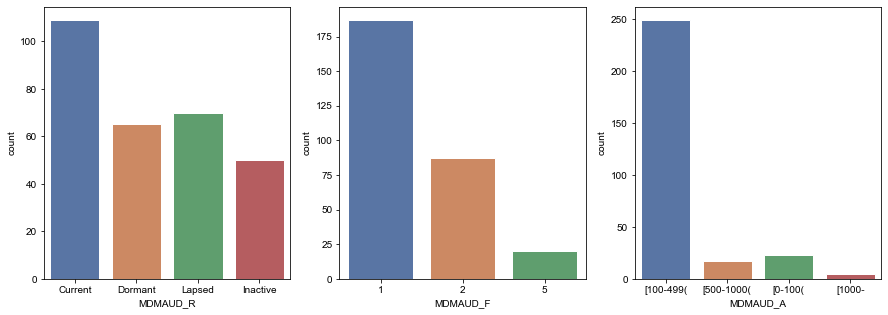

In [72]:
# Analyse some distributions.
donors_df["MDMAUD_R"].replace({"C":"Current","L":"Lapsed","I":"Inactive","D":"Dormant"},inplace=True)
donors_df["MDMAUD_A"].replace({"C":"[100-499(","L":"[0-100(","M":"[500-1000(","T":"[1000-"},inplace=True)

temp_mdmaud = donors_df[mdmaud].copy()
temp_mdmaud = temp_mdmaud[temp_mdmaud["MAJOR"]=="1"].drop(columns="MAJOR")

fig, ax = plt.subplots(ncols=3,figsize=(15,5))
sns.set_theme()

for i,column in enumerate(temp_mdmaud.columns):
    sns.countplot(x=column,data=temp_mdmaud,ax=ax[i])

Tiago: I'd be interested in clustering these and profile them, like so...

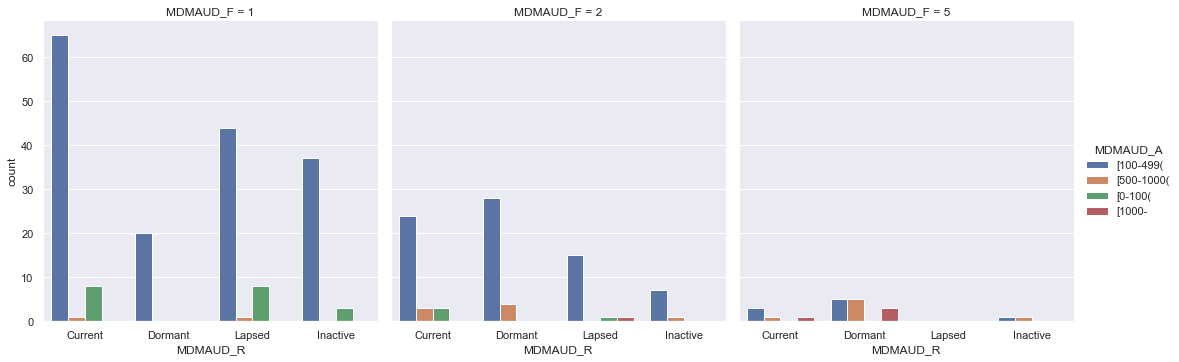

In [73]:
ax = sns.catplot(x="MDMAUD_R",hue="MDMAUD_A",col="MDMAUD_F",kind="count",data=temp_mdmaud)

We can see quickly that the Top donors are all frequent givers, but most are lapsed or dormant. <br>
Moreover, the most common type of major donor are those who have recently given once (more than 100 dollars).
There is a huge dropoff from 2 to 5 recent gifts. 
For all people that gave more than 100 dollars once, it is uncommon that they give lower values and then stop.

Tiago: There may be some ways for us to join this info with the info on giving history, especially because there is probably a huge amount of overlap... 

### **Exploring Mailings** <a name="Mailings"></a>

In [74]:
donors_df[mailings].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95412 entries, 0 to 95411
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   SOLP3     95412 non-null  object
 1   SOLIH     95412 non-null  object
 2   CARDPROM  95412 non-null  int64 
 3   CARDPM12  95412 non-null  int64 
 4   NUMPROM   95412 non-null  int64 
 5   NUMPRM12  95412 non-null  int64 
 6   HIT       95412 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 5.1+ MB


In [75]:
# Fix dtypes
donors_df.loc[:,["SOLP3","SOLIH"]] = donors_df.loc[:,["SOLP3","SOLIH"]].astype(int)

In [76]:
# Merge both solicitation features into a single "solicitation limit" column.
donors_df["SOLIC"]=donors_df.loc[:,["SOLP3","SOLIH"]].min(axis=1)

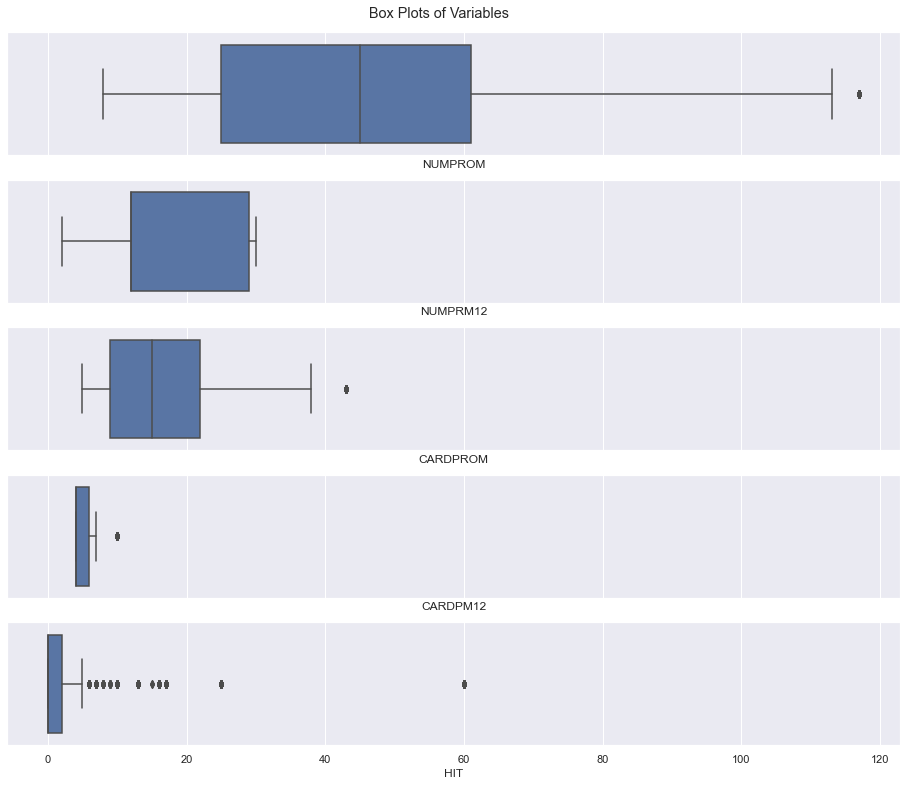

In [77]:
# CARDPROM, NUMPROM, HIT


cnh = ["NUMPROM","NUMPRM12","CARDPROM","CARDPM12","HIT"]

fig, ax = plt.subplots(nrows=len(cnh),figsize=(16,12),sharex=True)
sns.set_theme()

for i,column in enumerate(donors_df[cnh].columns):
    sns.boxplot(data=donors_df[column],x=donors_df[column],ax=ax[i])
plt.suptitle("Box Plots of Variables")
fig.subplots_adjust(top=0.95)
plt.show()

In [78]:
# Outlier detection and quantification.
# Manual filters first.

filters1 = (
    (donors_df['CARDPM12']<=10) & #(donors_df['HIT']<=10) &
    (donors_df['NUMPROM']<=118)
)

df_1 = donors_df[filters1]

remove_nr = np.round(df_1.shape[0] / donors_df.shape[0], 4)
print('Manually removing outliers from this group would remove {}% of the data.'.format(np.round((1-remove_nr)*100),3))

# IQR method second.
#q25 = donors_df.quantile(.25)
#q75 = donors_df.quantile(.75)
#iqr = (q75 - q25)
#
#upper_lim = q75 + 1.5 * iqr
#lower_lim = q25 - 1.5 * iqr

filters2 = []
for feat in cnh:
    llim = lower_lim[feat]
    ulim = upper_lim[feat]
    filters2.append(donors_df[feat].between(llim, ulim, inclusive=True))

filters2 = pd.Series(np.all(filters2, 0))
df_2 = donors_df[filters2]

remove_nr = np.round(df_2.shape[0] / donors_df.shape[0], 4)
print('Removing outliers with the IQR method from this group would remove {}% of the data.'.format(np.round((1-remove_nr)*100),3))

Manually removing outliers from this group would remove 1.0% of the data.
Removing outliers with the IQR method from this group would remove 26.0% of the data.


Most of the outliers come from HIT, which usefulness is questionable. We will probably not use that feature.

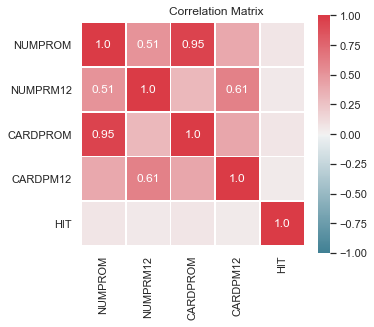

In [79]:
# sns.pairplot(data=donors_df[cnh],kind="hist")
# plt.show()
# This is computationally expensive to process, takes about 2 to 3 minutes. It shows no clear distribution in HIT, and no correlation with other variables.
# The distributions in numprom and cardprom seem uniform, with no specific structure.
# There is an obvious correlation between cardprom and numprom.
# A corrmatrix/heatmap will probably show the same results, more quickly.

# Prepare figure
fig = plt.figure(figsize=(5, 4))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(donors_df[cnh].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=12)
plt.show()

We conclude that HIT doesn't look like a valuable metric, but we should still keep it for clustering and exclude it if there's no information to be gained from it later. Although NUMPROM and CARDPROM are highly correlated in the sense that almost all promotions are card promotions, let's keep them until later where we can compare them to cardgifts. 
Also curious is that 0.61 of promotions were card promotions in the last 12 months, but not before.

### **Exploring Other mail offers** <a name="Other_mail"></a>

In [80]:
donors_df[other_offers].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95412 entries, 0 to 95411
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MBCRAFT   42558 non-null  float64
 1   MBGARDEN  42558 non-null  float64
 2   MBBOOKS   42558 non-null  float64
 3   MBCOLECT  42498 non-null  float64
 4   MAGFAML   42558 non-null  float64
 5   MAGFEM    42558 non-null  float64
 6   MAGMALE   42558 non-null  float64
 7   PUBCULIN  42558 non-null  float64
 8   PUBHLTH   42558 non-null  float64
 9   PUBDOITY  42558 non-null  float64
 10  PUBNEWFN  42558 non-null  float64
 11  PUBPHOTO  42558 non-null  float64
 12  PUBOPP    42558 non-null  float64
dtypes: float64(13)
memory usage: 9.5 MB


It is not a coincidence that all of these have the same amount of missing records. 
We find no reason to use these variables.

### **Exploring File Flags** <a name="Flags"></a>

### **Exploring Fields to Keep** <a name ="Fieldstokeep"></a> 

In [81]:
print(fields_to_keep)

['ODATEDW', 'FISTDATE', 'DOB', 'MAXADATE', 'GENDER', 'NUMCHLD', 'CARDPROM', 'CARDPM12', 'NUMPROM', 'NUMPRM12', 'HIT', 'RFA_2F', 'RFA_2A', 'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A', 'MAJOR', 'AVGGIFT', 'RAMNTALL', 'NGIFTALL', 'CARDGIFT', 'TIMELAG', 'POP903', 'HHP2', 'RHP4', 'AGE904', 'AGE907', 'MARR1', 'HV2', 'ETH1', 'HHAS4', 'TPE11', 'LFC1', 'EC1', 'AFC1', 'AFC4', 'VOC1', 'IC4', 'DOMAIN_L', 'DOMAIN_S', 'WEALTH']


In [82]:
donors_df[fields_to_keep].dtypes

ODATEDW     datetime64[ns]
FISTDATE    datetime64[ns]
DOB                 object
MAXADATE            object
GENDER              object
NUMCHLD            float64
CARDPROM             int64
CARDPM12             int64
NUMPROM              int64
NUMPRM12             int64
HIT                  int64
RFA_2F               int64
RFA_2A              object
MDMAUD_R            object
MDMAUD_F            object
MDMAUD_A            object
MAJOR               object
AVGGIFT            float64
RAMNTALL           float64
NGIFTALL             int64
CARDGIFT             int64
TIMELAG            float64
POP903             float64
HHP2               float64
RHP4               float64
AGE904             float64
AGE907             float64
MARR1              float64
HV2                float64
ETH1               float64
HHAS4              float64
TPE11              float64
LFC1               float64
EC1                float64
AFC1               float64
AFC4               float64
VOC1               float64
I

## **Data Preprocessing** <a name ="DP"></a> 

To-do:
* Encode all categorical and relevant variables

In [83]:
donors_df.describe()

,Unnamed: 0,TCODE,NUMCHLD,INCOME,WEALTH1,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,...,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,SUM,DOMAIN_S,WEALTH,SOLIC
count,95412.000000,95412.000000,95412.000000,74126.000000,50680.000000,95412.000000,42558.000000,42558.000000,42558.000000,42498.000000,...,95412.000000,85439.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.0,95412.000000,95412.000000,95412.000000
mean,47705.500000,54.223117,0.198329,3.886248,5.345699,3.321438,0.152075,0.059166,1.116382,0.063932,...,17.313127,8.093739,13.347786,95778.176959,0.500618,1.910053,0.0,1.912045,5.012147,93.138106
std,27543.216279,953.844476,0.590066,1.854960,2.742490,9.306899,0.470023,0.262078,1.669967,0.297344,...,13.956630,8.213242,10.769997,55284.596094,0.500002,1.072749,0.0,0.745453,2.820224,21.968075
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.285714,1.000000,0.000000,1.000000,0.0,1.000000,0.000000,0.000000
25%,23852.750000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,4.000000,8.384615,47910.750000,0.000000,1.000000,0.0,1.000000,3.000000,99.000000
50%,47705.500000,1.000000,0.000000,4.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,15.000000,6.000000,11.636364,95681.500000,1.000000,2.000000,0.0,2.000000,5.000000,99.000000
75%,71558.250000,2.000000,0.000000,5.000000,8.000000,3.000000,0.000000,0.000000,2.000000,0.000000,...,20.000000,11.000000,15.477955,143643.500000,1.000000,3.000000,0.0,2.000000,8.000000,99.000000
max,95411.000000,72002.000000,7.000000,7.000000,9.000000,241.000000,6.000000,4.000000,9.000000,6.000000,...,1000.000000,1088.000000,1000.000000,191779.000000,1.000000,4.000000,0.0,4.000000,9.000000,99.000000


In [84]:
donors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95412 entries, 0 to 95411
Columns: 481 entries, Unnamed: 0 to SOLIC
dtypes: datetime64[ns](3), float64(68), int32(3), int64(286), object(121)
memory usage: 349.0+ MB


---

## Feature Engineering <a name="FE"></a>

##### **RECENCY** <a name="Recency"></a>

<font size="2"> Because the data's values for recency are not coherent and consistent, we derive our own recency metric, from the LASTDATE feature. </font>

In [85]:
# We will calculate this using the date of the last donation made for each record. This is LASTDATE.

donors_df["RECENCY"] = (current_time - donors_df["LASTDATE"]).dt.days

# The other two metrics are already preprocessed.
fields_to_keep.extend(["RECENCY"])

##### **Age** <a name="Age"></a>

<font size="2">
About 25% of records (23883) are missing date of birth. 
Also, 19 people under 6 donated. This is likely not invalid data per se; maybe their parents donated in their name. But it does mean their usefulness for clustering is marginal at best. </font>

In [86]:
# Deriving Age. Quick and dirty way of doing it.
age_series = 2018 - donors_df["DOB"].str.split(pat=r"-",n=1,expand=True)[0].astype(float)
age_series.describe()

count    71529.000000
mean        59.705378
std         16.786761
min          1.000000
25%         47.000000
50%         60.000000
75%         74.000000
max         88.000000
Name: 0, dtype: float64

In [87]:
(age_series < 6).value_counts()

False    95391
True        21
Name: 0, dtype: int64

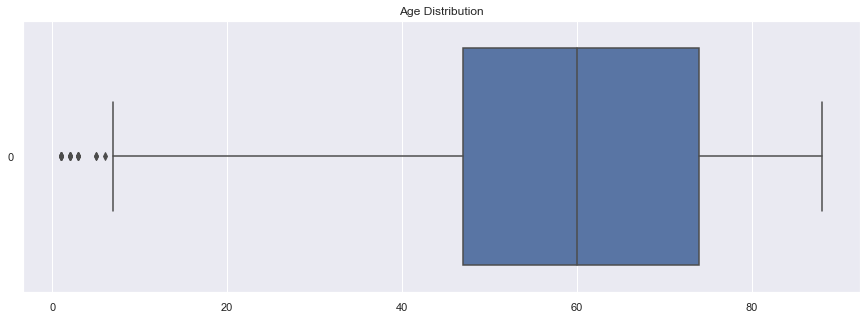

In [88]:
plt.figure(figsize=(15,5))
sns.boxplot(data=age_series,orient="h")
plt.title("Age Distribution")
plt.show()

In [89]:
# Put this back into the dataframe, where DOB is, and drop DOB. Store as Float to account for np.nan.
donors_df.insert(donors_df.columns.get_loc("DOB"),"AGE",age_series.astype("float32"))
donors_df.drop(columns="DOB",inplace=True)

fields_to_keep.remove("DOB")
fields_to_keep.extend(["AGE"])

##### **Antiquity** <a name="Antiquity"></a>

Because I found no other word to describe the amount of time someone has been a donor for. Alternatives: membership, donorship.

For this we have the option of using ODATEDW or FISTDATE. We prefer FISTDATE for the following reasons:
* Month is defined for every record, unlike ODATEDW.
* It comes from the giving history file, and is consistent with the data there, which we use extensively.
* ODATEDW's earliest recorded gift is 2003, whilst FISTDATE is 1969. There is discrepancy between many of the dates. Our assumption here is that ODATEDW is a more recent variable that did not inherit the values from FISTDATE, and registered the date of the first gift after that system was implemented. If that assumption holds, then it is not capturing a complete picture of the lifetime of a donor, and is therefore misleading.


In [90]:
donors_df["ANTIQUITY"] = (current_time - donors_df["FISTDATE"])/(datetime.timedelta(days=365)) # Shows Antiquity in terms of years.

In [91]:
fields_to_keep.extend(["ANTIQUITY"])
fields_to_keep.remove("FISTDATE")
fields_to_keep.remove("ODATEDW")

##### **PROM_TIMELAG** <a name="Prom_timelag"></a>

Average time between sent promotions.

---

---

---

## Feature Set <a name="FS"></a>

We will use fields_to_keep. From here, separate metric and categorical features.

In [95]:
print("Number of Variables to keep: {}\n".format(len(fields_to_keep)))
print(fields_to_keep)
metric_feat = metric_feats = census_u + ['NUMCHLD','CARDPROM','CARDPM12','NUMPROM','NUMPRM12','RAMNTALL','AVGGIFT','NGIFTALL','CARDGIFT','RECENCY','AGE','ANTIQUITY']#,'HIT','TIMELAG']
cat_feat = cat_feats = ['GENDER','WEALTH','RFA_2F','RFA_2A','MDMAUD_R','MDMAUD_F','MDMAUD_A','MAJOR','DOMAIN_L','DOMAIN_S']

Number of Variables to keep: 41

['MAXADATE', 'GENDER', 'NUMCHLD', 'CARDPROM', 'CARDPM12', 'NUMPROM', 'NUMPRM12', 'HIT', 'RFA_2F', 'RFA_2A', 'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A', 'MAJOR', 'AVGGIFT', 'RAMNTALL', 'NGIFTALL', 'CARDGIFT', 'TIMELAG', 'POP903', 'HHP2', 'RHP4', 'AGE904', 'AGE907', 'MARR1', 'HV2', 'ETH1', 'HHAS4', 'TPE11', 'LFC1', 'EC1', 'AFC1', 'AFC4', 'VOC1', 'IC4', 'DOMAIN_L', 'DOMAIN_S', 'WEALTH', 'RECENCY', 'AGE', 'ANTIQUITY']


In [96]:
## Additionally, remove outliers.

# Outlier detection and quantification.
# Manual filters first.

filters1 = (
    (donors_df['RAMNTALL']<=1000) & (donors_df['NGIFTALL']<=35) &
    (donors_df['MAXRAMNT']<=500) & (donors_df['AVGGIFT']<=100) &
    #(donors_df['TIMELAG']<=100) &
    (donors_df['CARDPM12']<=10) & #(donors_df['HIT']<=10) &
    (donors_df['NUMPROM']<=118)
)

df_1 = donors_df[filters1]

remove_nr = np.round(df_1.shape[0] / donors_df.shape[0], 4)
print('Manually removing outliers from this group would remove {}% of the data.'.format(np.round((1-remove_nr)*100),3))

# IQR method second.
q25 = donors_df.quantile(.25)
q75 = donors_df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for feat in metric_feat:
    llim = lower_lim[feat]
    ulim = upper_lim[feat]
    filters2.append(donors_df[feat].between(llim, ulim, inclusive=True))

filters2 = pd.Series(np.all(filters2, 0))
df_2 = donors_df[filters2]

remove_nr = np.round(df_2.shape[0] / donors_df.shape[0], 4)
print('Removing outliers with the IQR method from this group would remove {}% of the data.'.format(np.round((1-remove_nr)*100),3))


Manually removing outliers from this group would remove 3.0% of the data.
Removing outliers with the IQR method from this group would remove 76.0% of the data.


Suggestion: drop TIMELAG, drop HIT, as these are stacked with outliers and irrelevant data.

### Scaling

In [89]:
df_scaled = donors_df.copy()
scaler = MinMaxScaler()

# Choose one
scaler = MinMaxScaler()
# scaler = RobustScaler()

df_scaled.loc[:,metric_feat] = scaler.fit_transform(donors_df.loc[:,metric_feat])

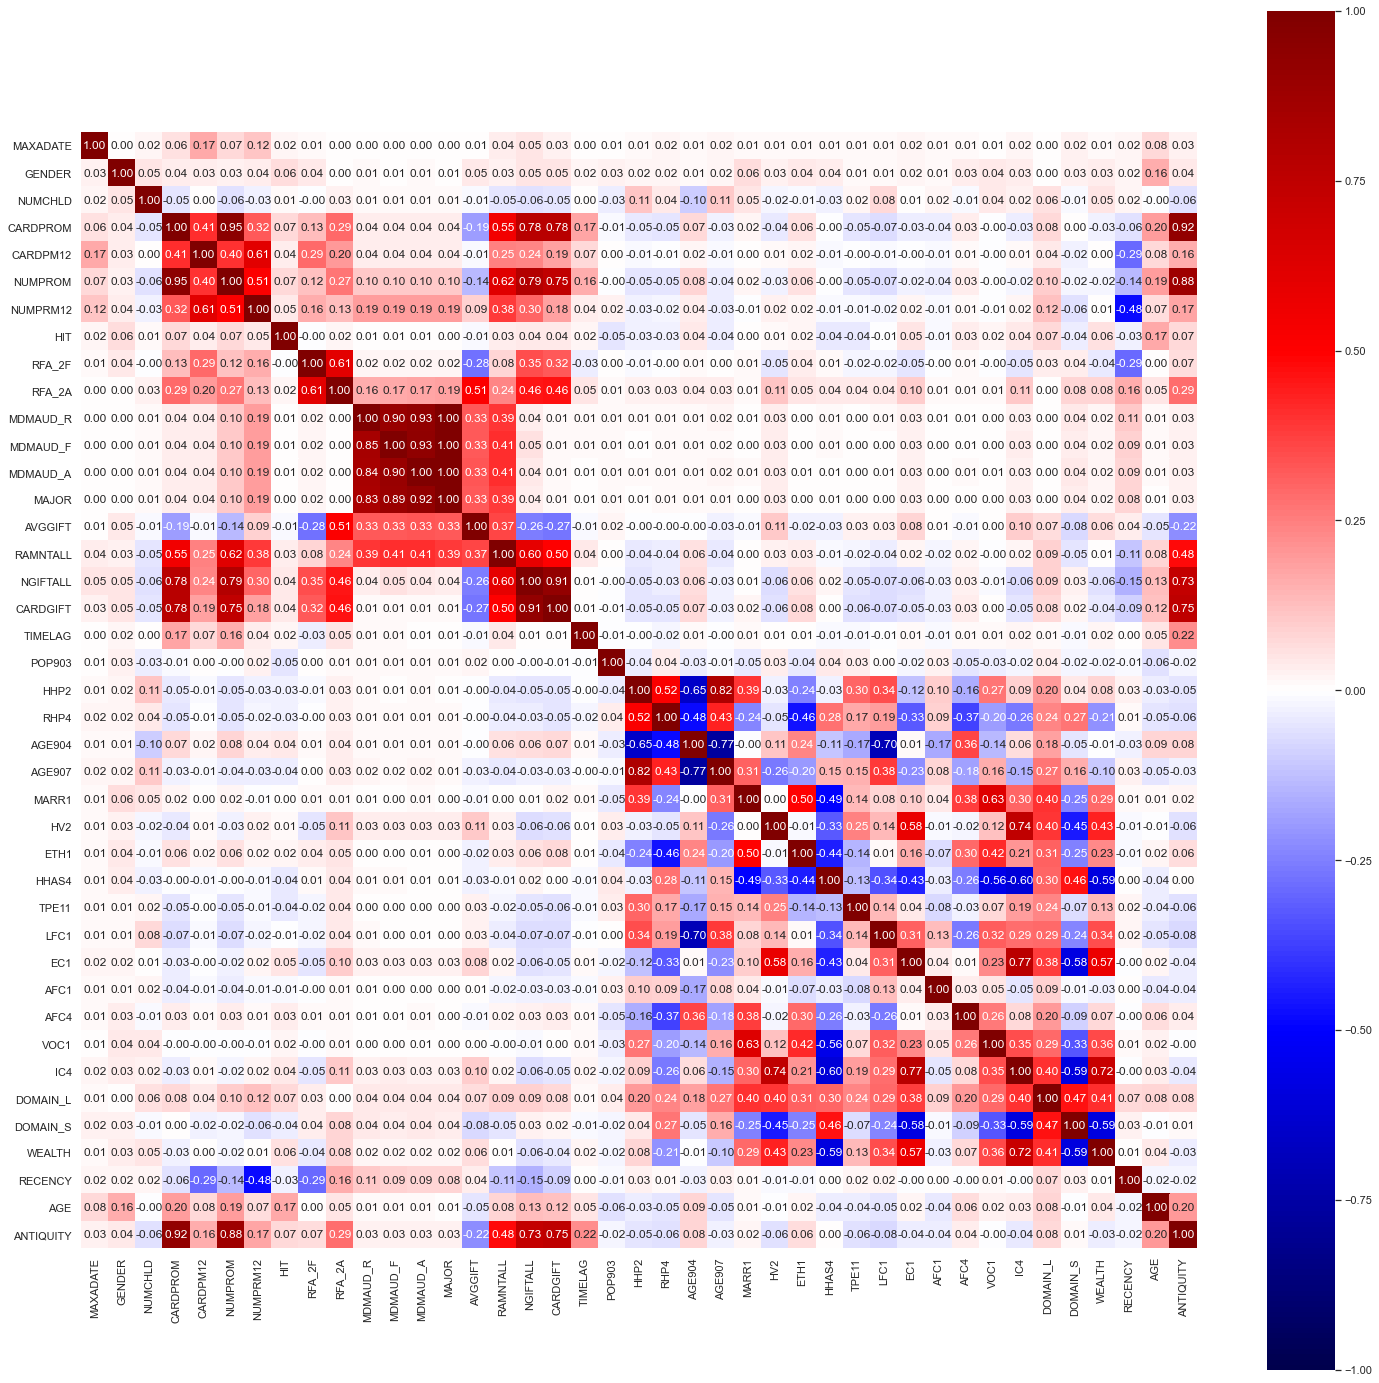

{'corr':            MAXADATE    GENDER   NUMCHLD  CARDPROM  CARDPM12   NUMPROM  \
 MAXADATE   1.000000  0.000907  0.021246  0.061007  0.169267  0.073082   
 GENDER     0.027013  1.000000  0.049821  0.036626  0.031829  0.030356   
 NUMCHLD    0.021246  0.049821  1.000000 -0.051567  0.001296 -0.059028   
 CARDPROM   0.061007  0.036626 -0.051567  1.000000  0.406926  0.949052   
 CARDPM12   0.169267  0.031829  0.001296  0.406926  1.000000  0.403414   
 NUMPROM    0.073082  0.030356 -0.059028  0.949052  0.403414  1.000000   
 NUMPRM12   0.117163  0.037308 -0.030548  0.321836  0.613361  0.512446   
 HIT        0.021195  0.064685  0.013847  0.070476  0.037823  0.074104   
 RFA_2F     0.014594  0.044230 -0.002450  0.131908  0.294564  0.120562   
 RFA_2A     0.004251  0.001679  0.027730  0.293830  0.197422  0.270597   
 MDMAUD_R   0.001259  0.000240  0.012997  0.038178  0.038166  0.103796   
 MDMAUD_F   0.001689  0.000211  0.012956  0.037071  0.037088  0.103739   
 MDMAUD_A   0.000775  0.000237

In [90]:
# This is a cute function that computes the correct relationship metric for all combinations of types of variables. Continuous continuous = pearson, cat cat = theil u, continuous cat = theil u.
# It takes a slight while but it is very informative.
associations(donors_df.loc[:,fields_to_keep],annot=True,cmap="seismic",theil_u=True,figsize=(25,25))

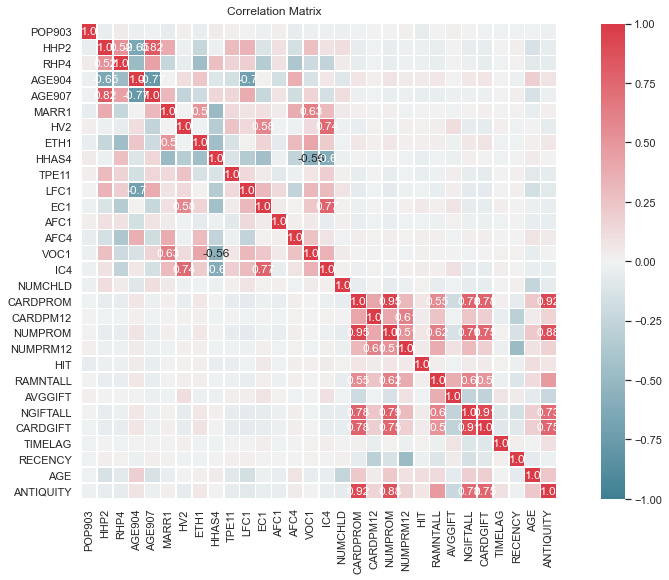

In [91]:
# Heat correlation matrix for all metric features.

# Prepare figure
fig = plt.figure(figsize=(16, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(donors_df[metric_feat].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=12)
plt.show()

Variables w/o any significant correlation:
NUMCHLD, TIMELAG, HIT.

In [92]:
# We shall further reduce this feature set and apply different clustering techniques.

# The first set is quite simple and aims to cluster the Recency Frequency Amount behaviors in the dataset, and connect these to the amount of promotions received.
# This is a similar set to what is used in RFM Analysis.
featset_g = ['NUMPROM','RECENCY',"AVGGIFT","NGIFTALL"]

# This set aims to characterize individual demographics of the dataset, and its respective giving behaviors.
featset_i =  ['AGE','NUMCHLD','ANTIQUITY']

# This set aims to characterize the donor's neighborhoods.
featset_n = census_u

# This is a complete set which aims to find links between giving behaviours, individual demographics, and the neighborhood of the donors.
featset_c = ['AGE','NUMCHLD','WEALTH','ANTIQUITY'] + census_u + ['NUMPROM','RECENCY',"AVGGIFT","NGIFTALL"]
             

---

## **PCA Analysis**<a name="PCA"></a>

As we have many variables, it is relevant to apply some measure of dimensionality reduction, with the added benefit of identifying the combination of features which capture the most variance of the dataset.

In [93]:
df_pca = df_scaled[metric_feat].copy()

In [94]:
pca = PCA()
pca_feat = pca.fit_transform(df_pca.drop(columns = ["AGE", "TIMELAG"]))
cov_matrix = df_pca.drop(columns = ["AGE", "TIMELAG"]).cov()
pd.DataFrame(pca.components_.T @ np.diag(pca.explained_variance_) @ pca.components_, 
             index=cov_matrix.index, 
             columns=cov_matrix.columns)
pd.DataFrame(df_pca.drop(columns = ["AGE", "TIMELAG"]).values @ pca.components_.T, 
             index=df_pca.index,
             columns=[f"PC{i}" for i in range(pca.n_components_)])

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27
0,-1.151398,0.777987,-0.436679,-0.969419,0.180029,-0.156011,-0.046905,0.015365,-0.060904,0.132049,...,0.014384,-0.059975,0.314792,-0.571420,0.021030,0.108025,0.009635,0.011236,0.012834,0.012509
1,-1.801919,0.002273,0.097275,-1.025390,0.084383,-0.400999,0.055624,0.282302,-0.056505,0.201390,...,0.090991,-0.055784,0.292270,-0.574212,0.061276,0.116951,0.003014,0.008081,0.002585,0.009157
2,-1.135535,0.732959,-0.460143,-0.994559,0.151258,-0.095459,0.039872,0.052574,-0.091892,0.210670,...,0.043089,-0.041674,0.303617,-0.554267,0.040794,0.137326,-0.017666,0.016403,0.014203,0.009524
3,-1.018180,0.544774,-0.199060,-1.052541,0.130102,-0.171347,-0.039293,0.046833,-0.084753,0.136621,...,0.028850,-0.036109,0.305117,-0.529080,0.082109,0.131540,-0.001819,0.012225,0.014416,0.010459
4,-0.620121,0.711896,0.365185,-1.150391,0.127709,-0.256337,-0.232793,-0.051177,0.152831,0.384392,...,0.250820,-0.044264,0.326850,-0.576895,0.150835,0.126034,0.059525,0.033598,0.066599,0.022700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,-1.266190,0.119528,-0.432493,-0.969869,-0.072640,-0.005971,-0.041901,0.018615,-0.105635,0.208701,...,0.023531,-0.007722,0.270095,-0.593637,0.050416,0.121108,-0.013268,0.019991,0.003110,0.013094
95408,-1.628744,0.047262,-0.403113,-1.033865,-0.136778,-0.133196,-0.183124,0.281706,-0.106997,0.244929,...,0.008979,-0.052342,0.301634,-0.589671,0.030699,0.127505,-0.015712,0.015232,0.005127,0.010448
95409,-0.972863,0.433787,-0.397410,-0.761040,-0.301498,0.028980,0.039728,0.139046,-0.136358,0.190996,...,0.017635,-0.058990,0.279844,-0.590871,0.043929,0.132759,-0.022976,0.008799,0.001488,0.005198
95410,-1.462101,1.041219,0.083999,-0.843832,-0.302482,-0.137121,0.095942,0.087855,-0.085805,0.269285,...,0.016013,-0.039874,0.375156,-0.603126,0.030114,0.099952,0.046274,0.006325,-0.013810,0.008301


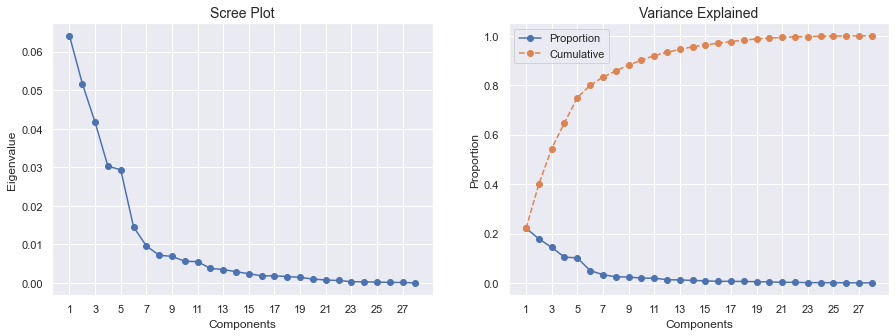

In [95]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [96]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=7)
pca_feat = pca.fit_transform(df_pca.drop(columns = ["AGE", "TIMELAG"]))
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

,PC0,PC1,PC2,PC3,PC4,PC5,PC6
0,0.054139,0.339759,-0.030510,-0.020585,0.036674,-0.045941,-0.039466
1,-0.596382,-0.435954,0.503443,-0.076556,-0.058972,-0.290926,0.063066
2,0.070002,0.294731,-0.053975,-0.045725,0.007903,0.014611,0.047311
3,0.187357,0.106546,0.207108,-0.103706,-0.013253,-0.061283,-0.031837
4,0.585416,0.273669,0.771353,-0.201558,-0.015645,-0.146258,-0.225347
...,...,...,...,...,...,...,...
95407,-0.060653,-0.318699,-0.026325,-0.021035,-0.215995,0.104095,-0.034452
95408,-0.423207,-0.390965,0.003055,-0.085030,-0.280133,-0.023136,-0.175648
95409,0.232674,-0.004441,0.008758,0.187794,-0.444853,0.139048,0.047170
95410,-0.256563,0.602991,0.490167,0.105003,-0.445837,-0.027059,0.103403


In [97]:
# Reassigning df to contain pca variables
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

,POP903,HHP2,RHP4,AGE904,AGE907,MARR1,HV2,ETH1,HHAS4,TPE11,...,RECENCY,AGE,ANTIQUITY,PC0,PC1,PC2,PC3,PC4,PC5,PC6
0,0.009350,0.293333,0.076923,0.388889,0.333333,0.616162,0.092217,0.929293,0.010101,0.178082,...,0.608819,0.689655,0.136870,0.054139,0.339759,-0.030510,-0.020585,0.036674,-0.045941,-0.039466
1,0.028162,0.433333,0.102564,0.277778,0.426667,0.696970,0.867682,0.676768,0.030303,0.397260,...,0.608819,0.517241,0.052214,-0.596382,-0.435954,0.503443,-0.076556,-0.058972,-0.290926,0.063066
2,0.075363,0.256667,0.102564,0.347222,0.306667,0.636364,0.077157,0.969697,0.111111,0.287671,...,0.608819,NaN,0.133258,0.070002,0.294731,-0.053975,-0.045725,0.007903,0.014611,0.047311
3,0.006158,0.305000,0.102564,0.305556,0.333333,0.636364,0.198477,0.616162,0.202020,0.164384,...,0.608819,0.793103,0.196306,0.187357,0.106546,0.207108,-0.103706,-0.013253,-0.061283,-0.031837
4,0.021468,0.371667,0.128205,0.333333,0.360000,0.424242,0.085279,0.020202,0.141414,0.328767,...,0.564723,0.885057,0.367630,0.585416,0.273669,0.771353,-0.201558,-0.015645,-0.146258,-0.225347


In [98]:
def _color_red_or_green(val):
    if val < -0.5:
        color = 'background-color: red'
    elif val > 0.5:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca[metric_feat + pca_feat_names].corr().loc[metric_feat, pca_feat_names]
loadings
loadings.style.applymap(_color_red_or_green)
# loadings.reset_index(drop=True).style.applymap(_color_red_or_green)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6
POP903,0.029721,-0.026057,0.043591,0.018280,-0.001986,0.003057,0.096043
HHP2,0.076025,-0.172221,0.053616,-0.682351,-0.409278,-0.362835,-0.035789
RHP4,0.423827,-0.209303,0.223463,-0.322369,-0.190075,-0.087773,0.274734
AGE904,-0.131302,0.240642,-0.119952,0.714169,0.432310,-0.265675,-0.171832
AGE907,0.237932,-0.107277,-0.069376,-0.719845,-0.446337,-0.119425,-0.038152
MARR1,-0.471969,0.186336,-0.445362,-0.337798,-0.234467,-0.476983,-0.275996
HV2,-0.641200,-0.254012,0.526229,0.137259,0.129050,-0.271830,0.322623
ETH1,-0.597751,0.387727,-0.647697,0.103255,0.013596,0.128827,0.171830
HHAS4,0.736914,-0.049756,0.122000,0.139461,0.089437,0.106301,0.055509
TPE11,-0.104245,-0.172421,0.181918,-0.215888,-0.111460,-0.421043,0.239822


In [99]:
df = df_pca.drop(columns= ["PC5", "PC6"]).copy()
# fields_to_keep.remove("RHP4")
# metric_feat.extend(["PC1", "PC2", "PC3","PC4"])

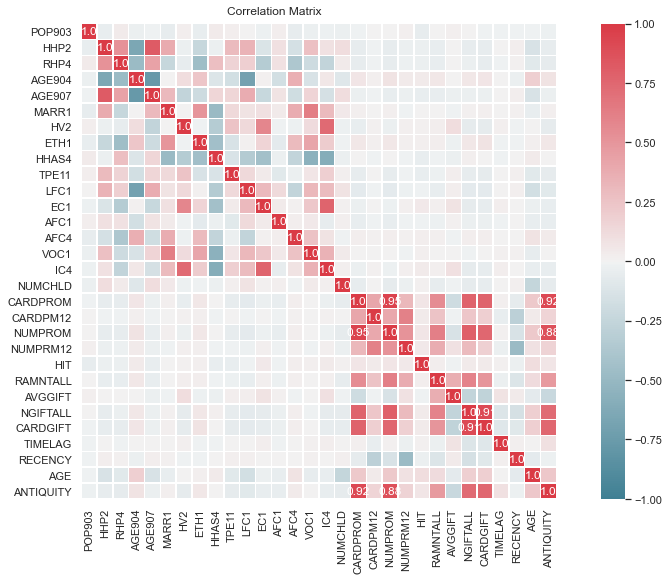

In [100]:
# Heat correlation matrix for all metric features.

# Prepare figure
fig = plt.figure(figsize=(16, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df[metric_feat].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.85
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=12)
plt.show()

In [101]:
# Add the selected PCA components to the DF. ?

---

# Clustering<a name="CL"></a>


* [RFM Analysis](#RFM)
* [Featset_g](#Featsetg)
* [Featset_i](#Featseti)
* [Featset_c](#Featsetc)

In [102]:
# Define functions for quality metrics. (from classes)
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust

In [103]:
# Define cluster profiling function (from classes)

def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

### **RFM Analysis**<a name="RFM"></a>

As we have data regarding recency, frequency, and amount of monetary value, we will start by applying RFM analysis / grouping.  
This is a relatively low-cost high potential analysis which will allow us to segment our donors meaningfully, before diving into more sophisticated clustering solutions. It is commonly used in database and direct marketing, which is PVA's marketing approach in this case. 

https://searchdatamanagement.techtarget.com/definition/RFM-analysis
https://www.eightleaves.com/2011/01/using-rfm-to-identify-your-best-customers/

Due to the size of the dataset, we will let the data define the thresholds for the categories of donors. 
As we are interested in lifetime metrics (because there is special concern in analysing lapsed donors), we determine the three pillars of RFM as follows:
* RECENCY: the time since the last donation. 
* FREQUENCY: the amount of donations.
* MONETARY: the average amount per donation.

For ease of interpretability and consistency, we opt for **independent binning**, which means we bin our dataset for these three areas individually. Also, as we want bins to roughly have the same number of records, we choose to bin by quantiles.

In [104]:
donors_df["RECENCY"].describe()

count    95412.000000
mean       772.842378
std        120.775617
min        334.000000
25%        700.000000
50%        762.000000
75%        853.000000
max       1037.000000
Name: RECENCY, dtype: float64

In [105]:
# Using quintilies raises an error because bin edges are not unique. 
# One workaround is to use less quantiles.
# 3s are the most recent donors. 
donors_df["RECENCY_Q"],retbins = pd.qcut(donors_df["RECENCY"],q=3,labels=[3,2,1],retbins=True)

# The below line is to visualize the group that corresponds to each bin. 
print(pd.concat(
    [donors_df["RECENCY_Q"].value_counts().sort_index() , pd.Series(retbins,name="Bin Edge",index=[4,3,2,1])],
    axis=1
).sort_index(ascending=False))

   RECENCY_Q  Bin Edge
4        NaN     334.0
3    37960.0     731.0
2    28132.0     792.0
1    29320.0    1037.0


In [106]:
# We follow the same procedure for Frequency.
donors_df["NGIFTALL_Q"],retbins = pd.qcut(donors_df["NGIFTALL"],q=3,labels=[1,2,3],retbins=True)

# The below line is to visualize the group that corresponds to each bin. 
print(pd.concat(
    [donors_df["NGIFTALL_Q"].value_counts().sort_index() , pd.Series(retbins,name="Bin Edge",index=[0,1,2,3])],
    axis=1
).sort_index(ascending=False))

   NGIFTALL_Q  Bin Edge
3     30115.0     237.0
2     33359.0      11.0
1     31938.0       4.0
0         NaN       1.0


In [107]:
# We follow the same procedure for Monetary Value.
donors_df["AVGGIFT_Q"],retbins = pd.qcut(donors_df["AVGGIFT"],q=3,labels=[1,2,3],retbins=True)

# The below line is to visualize the group that corresponds to each bin. 
print(pd.concat(
    [donors_df["AVGGIFT_Q"].value_counts().sort_index() , pd.Series(retbins,name="Bin Edge",index=[0,1,2,3])],
    axis=1
).sort_index(ascending=False))

   AVGGIFT_Q     Bin Edge
3    31801.0  1000.000000
2    31802.0    14.538462
1    31809.0     9.444444
0        NaN     1.285714


In [108]:
# Now we join these three into a column, RFM_score.
donors_df["RFM_S"] = donors_df["RECENCY_Q"].astype(str) + donors_df["NGIFTALL_Q"].astype(str) + donors_df["AVGGIFT_Q"].astype(str)

In [109]:
print("\nHere's a handy table showing the counts for each combination of categories.\n")
donors_df.groupby(["RECENCY_Q","NGIFTALL_Q"])["AVGGIFT_Q"].value_counts().unstack()


Here's a handy table showing the counts for each combination of categories.



AVGGIFT_Q                1     2     3
RECENCY_Q NGIFTALL_Q                  
3         1           1396  3183  7649
          2           5151  4616  2819
          3           8346  3249  1551
2         1            829  3083  3803
          2           3676  4647  2890
          3           5659  2511  1034
1         1            542  3390  8063
          2           2030  4598  2932
          3           4180  2525  1060

In [110]:
print("The most populated group is {}, with {} records.".format(donors_df["RFM_S"].value_counts().idxmax(),donors_df["RFM_S"].value_counts().max()))
print("The least populated group is {}, with {} records.".format(donors_df["RFM_S"].value_counts().idxmin(),donors_df["RFM_S"].value_counts().min()))

The most populated group is 331, with 8346 records.
The least populated group is 111, with 542 records.


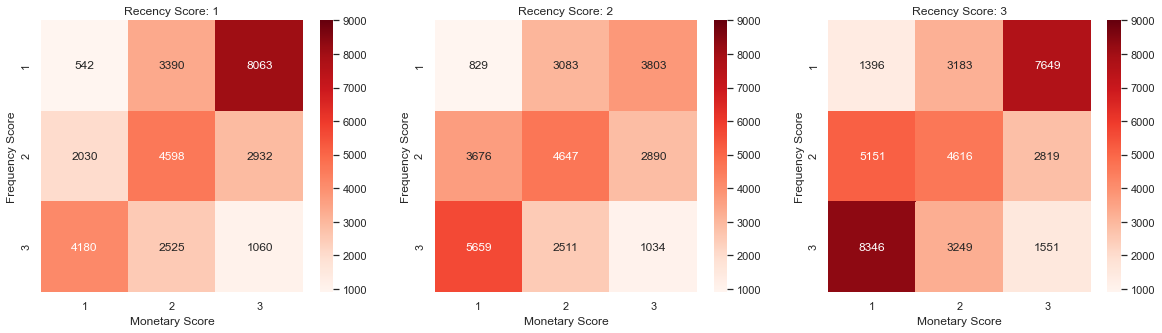

In [111]:
# And a visualization with a count heatmap.
bins = donors_df["RECENCY_Q"].unique().to_list()

fig, ax = plt.subplots(ncols=len(bins),figsize=(20,5))

for cat in bins:
    sns.heatmap(donors_df[donors_df["RECENCY_Q"]==cat].rename(columns={"NGIFTALL_Q":"Frequency Score","AVGGIFT_Q":"Monetary Score"})
                .groupby("Frequency Score")["Monetary Score"].value_counts().unstack(),
                ax=ax[cat-1],
                vmin=900,vmax=9000,
                cmap="Reds",
                annot=True,fmt=".4g",
               ).set_title("Recency Score: {}".format(cat,fontsize=13))
plt.show()


The edges of the squares are usually the most populated ones, which indicates there's always a skew towards either the lowest level of frequency or the lowest level of monetary value. The lower right edge, i.e. the best monetary and frequency value, has roughly half the amount of donors that its adjacents have. 

On the opposite end of the spectrum, i.e., the worst score has a relatively low amount of donors. 

One of the main conclusions from this analysis is that donors tend to either donate frequently, or donate high amounts. 
Also, for all levels of recency, infrequent donors that donate more are higher in count, and therefore there is potential in targetting these donors.

In [112]:
# Let's estabilish some relations between these groups and other variables.
donors_df.groupby("RFM_S")[metric_feat].mean()



,POP903,HHP2,RHP4,AGE904,AGE907,MARR1,HV2,ETH1,HHAS4,TPE11,...,NUMPRM12,HIT,RAMNTALL,AVGGIFT,NGIFTALL,CARDGIFT,TIMELAG,RECENCY,AGE,ANTIQUITY
RFM_S,,,,,,,,,,,,,,,,,,,,,
111,1098.391144,2.647712,4.581181,35.433579,25.313653,57.210332,1008.444649,84.062731,12.422509,23.848708,...,10.798893,2.702952,30.195129,8.361860,3.627306,2.055351,7.249077,896.461255,55.440216,4.227139
112,1254.315634,2.652558,4.467257,35.589086,25.188496,58.518584,1161.813569,84.255752,10.833333,24.189086,...,10.481416,2.919764,35.634702,11.978546,2.978171,1.767552,9.133038,914.655457,55.178761,4.063198
113,1227.556121,2.648439,4.506511,35.567655,24.901650,58.356319,1273.567159,83.946794,10.409525,24.506511,...,10.228451,2.502791,37.787278,21.255284,1.784944,1.175865,9.955795,896.325189,54.339409,3.108433
121,1191.068966,2.625350,4.431034,35.869458,25.300493,58.999507,1045.361084,86.291626,11.599015,23.871429,...,11.344828,3.370936,61.127729,7.793282,7.888177,4.549261,7.313793,895.767488,57.914490,6.518999
122,1266.500217,2.627421,4.412571,36.072858,24.924967,58.992605,1129.734232,85.592649,10.717051,23.932797,...,11.503915,3.523054,88.041338,11.794784,7.476077,4.244237,8.637886,916.323401,58.966995,7.009423
123,1238.958390,2.619055,4.406207,36.388472,24.333902,58.682128,1310.266030,86.056958,9.947135,24.203274,...,12.570600,3.383697,155.962977,21.144345,7.331855,4.127217,9.560368,918.855389,59.078449,7.106203
131,1200.400239,2.611565,4.400478,36.488995,24.833014,58.867225,992.270574,87.306459,11.270096,23.463636,...,11.488517,3.632536,138.039132,6.977981,20.187081,11.186842,6.410766,900.956699,62.936630,9.571397
132,1170.627327,2.605596,4.361980,36.609109,24.447129,59.064950,1104.977822,87.245149,10.549703,23.838020,...,12.218218,3.854653,206.831200,11.420399,18.121188,9.779010,7.144950,914.887129,62.473244,9.403088
133,1268.292453,2.566377,4.307547,37.161321,23.678302,58.209434,1313.801887,86.273585,10.498113,23.746226,...,13.901887,4.056604,373.557104,20.785125,17.940566,9.265094,7.189623,916.917925,62.625908,9.309382


       ANTIQUITY   CARDPROM  CARDPM12    NUMPROM   NUMPRM12    TIMELAG
RFM_S                                                                 
333     9.145232  28.477756  6.459703  84.035461  21.272083   8.152805
313     2.444403   7.337168  4.754347  18.280560  11.677866   9.256664
331     9.343133  26.482626  5.605679  68.295351  14.734723   6.854421
323     6.573224  20.789642  5.964881  55.230933  16.093650   9.421071
332     9.152753  27.721761  6.135118  76.176670  18.139735   7.410896
213     3.343978  10.393374  5.161977  25.543255  11.931370  10.919133
231     9.472730  26.633858  5.434529  66.193144  12.702244   6.775755
113     3.108433   8.959568  4.364753  22.528463  10.228451   9.955795
131     9.571397  26.905981  5.109809  66.782057  11.488517   6.410766


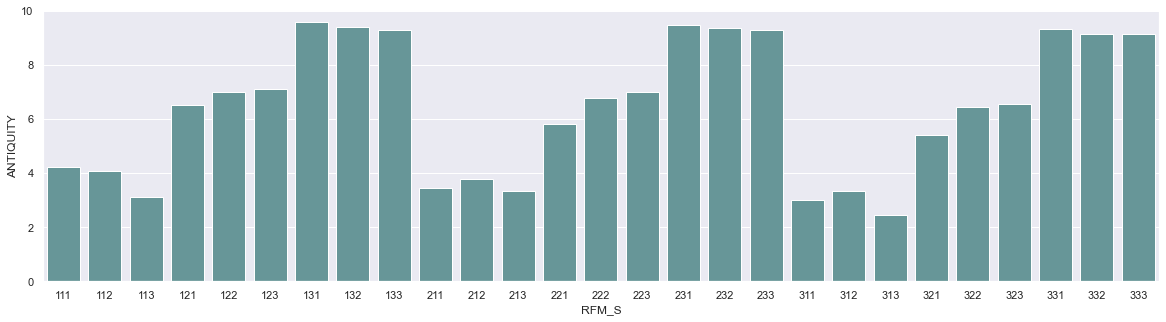

In [113]:
# Graphing this may be a nightmare, but I think it may be worth it, at least for the most interesting groups. 
print(donors_df.groupby("RFM_S")[metric_feat].mean().loc[["333","313","331","323","332","213","231","113","131"],
                                                   ["ANTIQUITY","CARDPROM","CARDPM12","NUMPROM","NUMPRM12","TIMELAG"]])

fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(data=donors_df.groupby("RFM_S")[metric_feat].mean(),
            y="ANTIQUITY", x=donors_df.groupby("RFM_S")[metric_feat].mean().index,
           color="cadetblue"
           )
plt.show()

There is a clear relation between years since first donation and the frequency of donations. That is to say, people tend to donate over time, so there is value in reaching out to people who have never donated. 

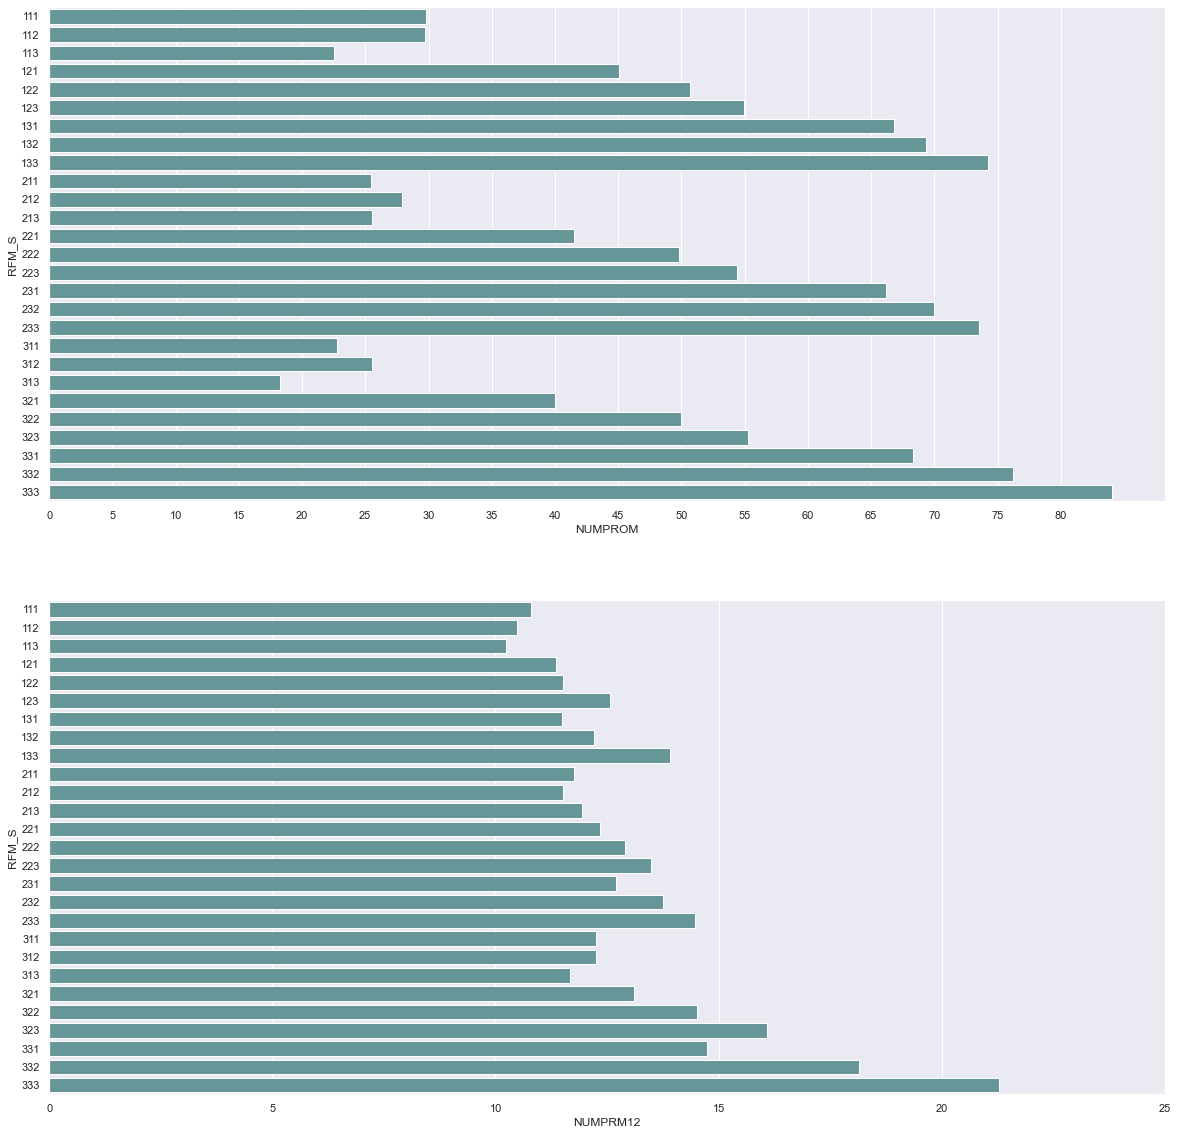

In [114]:
# NUMPROMS
fig, ax = plt.subplots(nrows=2,figsize=(20,20))
sns.barplot(data=donors_df.groupby("RFM_S")[metric_feat].mean(),
            y=donors_df.groupby("RFM_S")[metric_feat].mean().index, x="NUMPROM",
            color="cadetblue",
            ax=ax[0]
           ).set_xticks([i for i in np.arange(0,85,5)])

sns.barplot(data=donors_df.groupby("RFM_S")[metric_feat].mean(),
            y=donors_df.groupby("RFM_S")[metric_feat].mean().index, x="NUMPRM12",
            color="cadetblue",
            ax=ax[1]
           ).set_xticks([i for i in np.arange(0,30,5)])
plt.show()

As frequency increases, so does the number of promotions. 
Although for very infrequent donors the number of promotions doesn't have a structure, starting from frequency score 2 there is a clear upward trend in number of promotions vs monetary value.
In terms of recency, the number of promotions is relatively stable, e.g. 233 has the same average nr of promotions as 133.

For the data regarding the most recent promotions, it's interesting to see that while that there isn't too much of a difference between segments.

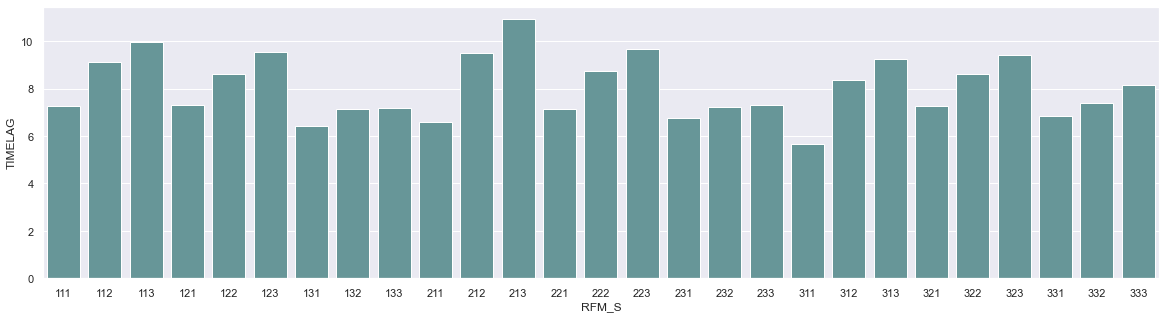

In [115]:
# TIMELAG ??
# Do note timelag is measured in months - so the lower the bar, the less time between the first and second donation.

fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(data=donors_df.groupby("RFM_S")[metric_feat].mean(),
            y="TIMELAG", x=donors_df.groupby("RFM_S")[metric_feat].mean().index,
           color="cadetblue"
           )
plt.show()

On average, donors with higher amounts of monetary value (avg amt of donation) took longer to donate again after the first donation. 

Timelag seems to have little relevance to frequency. While Frequency 3 also have the smallest timelags holding other factors constant, in the case of recency 3 the timelag is about the same for every level of frequency.

It also seems to have no great relevance to recency.

---

## **Featset_g**

In [116]:
df_g = df_scaled[featset_g].copy()

In [117]:
# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

In [118]:
'''# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_g, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_g.sample(frac = 0.4), hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)'''

"# Obtaining the R² scores for each cluster solution on demographic variables\nr2_scores = {}\nr2_scores['kmeans'] = get_r2_scores(df_g, kmeans)\n\nfor linkage in ['complete', 'average', 'single', 'ward']:\n    r2_scores[linkage] = get_r2_scores(\n        df_g.sample(frac = 0.4), hierarchical.set_params(linkage=linkage)\n    )\n\npd.DataFrame(r2_scores)"

In [119]:
"""# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Featset_g:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()"""

'# Visualizing the R² scores for each cluster solution on demographic variables\npd.DataFrame(r2_scores).plot.line(figsize=(10,7))\n\nplt.title("Featset_g:\nR² plot for various clustering methods\n", fontsize=21)\nplt.legend(title="Cluster methods", title_fontsize=11)\nplt.xlabel("Number of clusters", fontsize=13)\nplt.ylabel("R² metric", fontsize=13)\nplt.show()'

Results stabilize at 4 to 5 clusters in kmeans. Kmeans is the best algorithm for this feature set.
For agglomerative, best linkage is 'complete'.

In [120]:
# Visualizing the dendogram for this featureset.

# First set the clusterer and fit_predict it.

# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_g.sample(frac=0.4))

array([38164, 19384, 23184, ...,     6,     2,     0], dtype=int64)

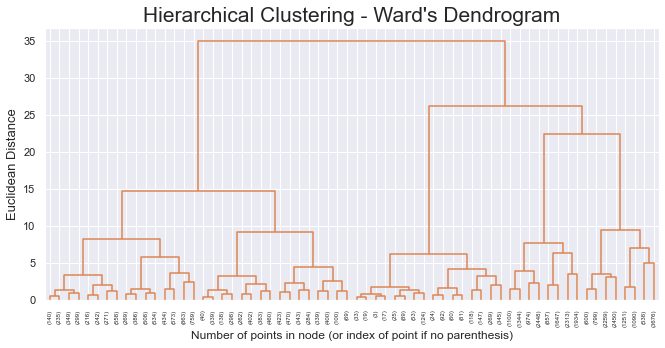

In [121]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

From the dendogram, 4 to 6 clusters.

In [122]:
# Plot Inertia for the n clusters used.
range_clust = list(range(3,9))
inertia = []
for n_clus in range_clust:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=10, random_state=1)
    kmclust.fit(df_g)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

inertia = dict(zip(range_clust,inertia))

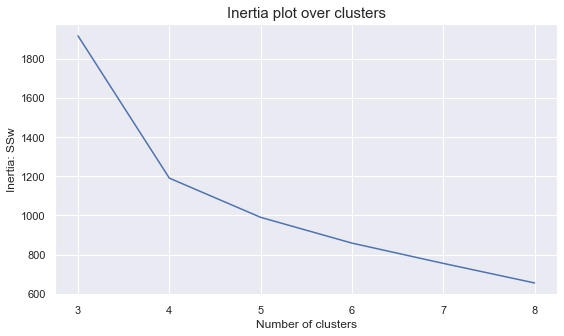

In [123]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(pd.Series(inertia))
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [124]:
# Apply kmeans for the number of clusters defined.
kmclust = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=1,verbose=0)
km_labels = kmclust.fit_predict(df_g)

In [125]:
# Characterizing the final clusters
df_concat = pd.concat((donors_df[featset_g], pd.Series(km_labels, name='g_labels')), axis=1)
df_concat.groupby('g_labels').mean()

,NUMPROM,RECENCY,AVGGIFT,NGIFTALL
g_labels,,,,
0,27.661623,729.590101,14.005239,4.371118
1,74.854696,407.546445,15.214569,16.644785
2,61.685547,939.624620,13.019574,13.054071
3,26.717066,889.699757,16.437023,3.313938
4,65.302016,740.812221,11.276450,15.185042


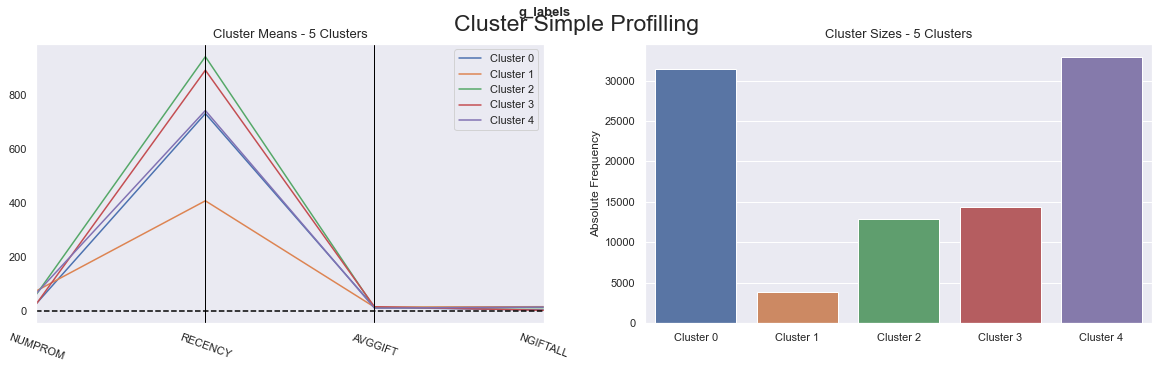

In [126]:
# Profilling the clusters from this solution.
cluster_profiles(
    df = df_concat,
    label_columns = ['g_labels'],
    figsize = (20, 5), 
    compar_titles = ["g_labels"]
)

## **Featset_i**

In [127]:
df_i = df_scaled[featset_i].dropna(axis=0,how="any").copy()

In [128]:
# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

In [129]:
"""# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_g, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_g.sample(frac = 0.4), hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)"""

"# Obtaining the R² scores for each cluster solution on demographic variables\nr2_scores = {}\nr2_scores['kmeans'] = get_r2_scores(df_g, kmeans)\n\nfor linkage in ['complete', 'average', 'single', 'ward']:\n    r2_scores[linkage] = get_r2_scores(\n        df_g.sample(frac = 0.4), hierarchical.set_params(linkage=linkage)\n    )\n\npd.DataFrame(r2_scores)"

In [130]:
"""# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Featset_i:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()"""

'# Visualizing the R² scores for each cluster solution on demographic variables\npd.DataFrame(r2_scores).plot.line(figsize=(10,7))\n\nplt.title("Featset_i:\nR² plot for various clustering methods\n", fontsize=21)\nplt.legend(title="Cluster methods", title_fontsize=11)\nplt.xlabel("Number of clusters", fontsize=13)\nplt.ylabel("R² metric", fontsize=13)\nplt.show()'

Best linkage is ward. Kmeans is only slightly better than that.
Best n clusters is between 4 and 6 - likely 5.

In [131]:
# Visualizing the dendogram for this featureset.

# First set the clusterer and fit_predict it.

# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_i.sample(frac=0.6,axis=0))

array([42916, 42915, 42914, ...,     5,     2,     0], dtype=int64)

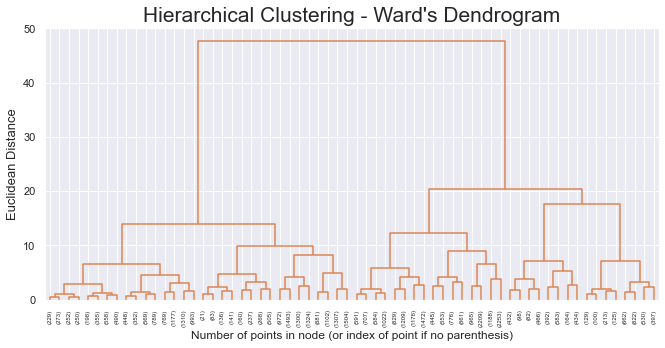

In [132]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

From the dendogram, 4 to 5 clusters.

In [133]:
# Plot Inertia for the n clusters used.
range_clust = list(range(3,8))
inertia = []
for n_clus in range_clust:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=10, random_state=1)
    kmclust.fit(df_i)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

inertia = dict(zip(range_clust,inertia))

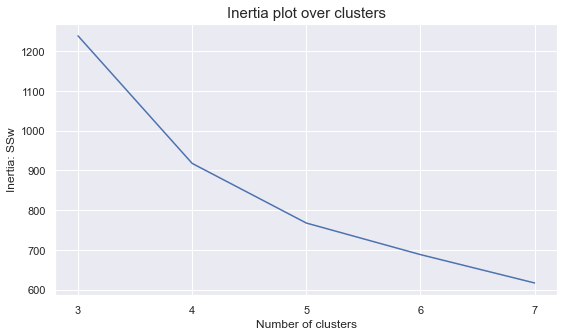

In [134]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(pd.Series(inertia))
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.xticks(range_clust)
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [135]:
# Apply kmeans for the number of clusters defined.
kmclust = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=1,verbose=0)
km_labels = kmclust.fit_predict(df_i)

In [136]:
# Characterizing the final clusters
df_concat = pd.concat((donors_df[featset_i], pd.Series(km_labels, name='i_labels')), axis=1)
df_concat.groupby('i_labels').mean()

,AGE,NUMCHLD,ANTIQUITY
i_labels,,,
0.0,59.867165,0.198853,6.286167
1.0,59.587292,0.201027,6.306852
2.0,59.839817,0.192483,6.303464
3.0,59.412926,0.199038,6.236407
4.0,59.838337,0.195402,6.260700


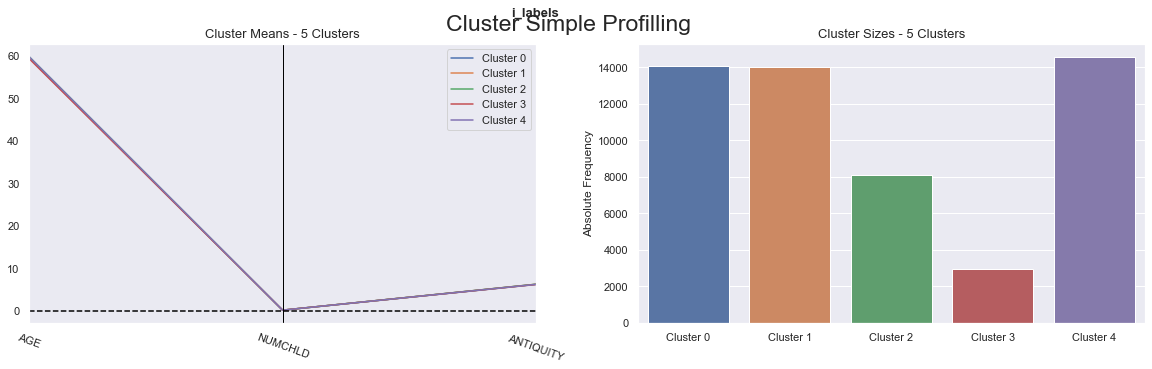

In [137]:
# Profilling the clusters from this solution.
cluster_profiles(
    df = df_concat,
    label_columns = ['i_labels'],
    figsize = (20, 5), 
    compar_titles = ["i_labels"]
)

---

## **Featset_c**

In [138]:
df_c = df_scaled[featset_c].drop(columns = ["AGE"]).copy()

In [139]:
# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

In [140]:
"""# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_c, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_g.sample(frac = 0.4), hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)"""

"# Obtaining the R² scores for each cluster solution on demographic variables\nr2_scores = {}\nr2_scores['kmeans'] = get_r2_scores(df_c, kmeans)\n\nfor linkage in ['complete', 'average', 'single', 'ward']:\n    r2_scores[linkage] = get_r2_scores(\n        df_g.sample(frac = 0.4), hierarchical.set_params(linkage=linkage)\n    )\n\npd.DataFrame(r2_scores)"

In [141]:
"""# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Featset_c:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()"""

'# Visualizing the R² scores for each cluster solution on demographic variables\npd.DataFrame(r2_scores).plot.line(figsize=(10,7))\n\nplt.title("Featset_c:\nR² plot for various clustering methods\n", fontsize=21)\nplt.legend(title="Cluster methods", title_fontsize=11)\nplt.xlabel("Number of clusters", fontsize=13)\nplt.ylabel("R² metric", fontsize=13)\nplt.show()'

Best linkage is ward. Kmeans is only slightly better than that. Performance doesn't improve much after 4 n clusters.

In [142]:
# Visualizing the dendogram for this featureset.

# First set the clusterer and fit_predict it.

# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_c.sample(frac=0.4,axis=0))

array([24314, 25137, 37615, ...,     3,     1,     0], dtype=int64)

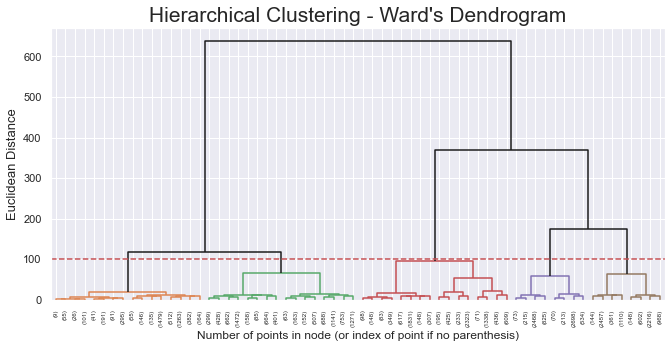

In [143]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

From the dendogram 5 clear clusters.

In [144]:
# Plot Inertia for the n clusters used.
range_clust = list(range(3,8))
inertia = []
for n_clus in range_clust:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=10, random_state=1)
    kmclust.fit(df_c)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

inertia = dict(zip(range_clust,inertia))

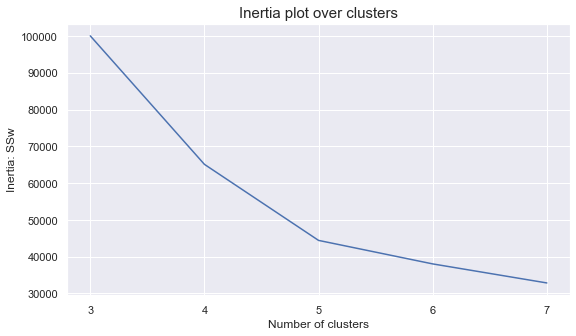

In [145]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(pd.Series(inertia))
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.xticks(range_clust)
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [146]:
# Apply kmeans for the number of clusters defined.
kmclust = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=1,verbose=0)
km_labels = kmclust.fit_predict(df_c)

In [147]:
# Characterizing the final clusters
df_concat = pd.concat((donors_df[featset_c], pd.Series(km_labels, name='c_labels')), axis=1)
df_concat.groupby('c_labels').mean()

,AGE,NUMCHLD,WEALTH,ANTIQUITY,POP903,HHP2,RHP4,AGE904,AGE907,MARR1,...,LFC1,EC1,AFC1,AFC4,VOC1,IC4,NUMPROM,RECENCY,AVGGIFT,NGIFTALL
c_labels,,,,,,,,,,,,,,,,,,,,,
0,61.276272,0.161107,0.566715,6.300452,1214.673041,2.584765,4.769375,36.104242,26.196046,52.060748,...,57.676636,12.021330,0.620273,14.645866,85.208411,280.373688,46.786341,771.888929,12.704825,9.948023
1,58.986404,0.216626,6.508047,6.274297,1190.856617,2.627961,4.433398,35.979399,24.225351,59.666796,...,68.017063,12.936369,0.621183,16.110906,94.558168,454.261415,47.016190,772.462530,13.289633,9.557295
2,59.856262,0.190615,4.516747,6.410047,1270.518924,2.604280,4.540368,36.241202,24.734965,58.160571,...,64.995541,12.492595,0.646106,15.850629,92.887839,389.368544,47.811402,772.576995,12.891109,9.994267
3,61.153713,0.163793,2.497014,6.450658,1330.365562,2.577369,4.547386,36.563613,25.173822,57.086545,...,61.590827,12.234759,0.721095,15.641931,91.137311,334.316486,47.862970,772.815021,12.736386,10.224307
4,58.442207,0.235330,8.510068,6.065344,1157.886926,2.674296,4.048878,36.185711,23.975088,62.936257,...,69.675273,14.173033,0.432695,15.864443,95.824748,614.864649,45.743792,773.937039,14.566552,8.682808


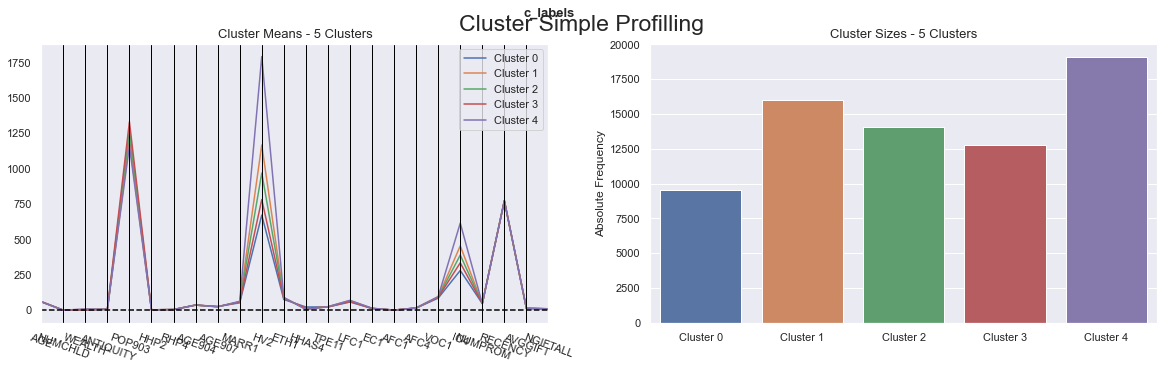

In [148]:
# Profilling the clusters from this solution.
cluster_profiles(
    df = df_concat,
    label_columns = ['c_labels'],
    figsize = (20, 5), 
    compar_titles = ["c_labels"]
)

---

### **Hierarchical Clustering**<a name="Hierarchical"></a>

In [149]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_cluster[featset_g].sample(frac = 0.3)[featset_g])

NameError: name 'df_cluster' is not defined

In [ ]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

Points towards 5 clusters ?

---

### Cluster method Comparison <a name="Comparison"></a>

In [ ]:
# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

In [ ]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_cluster[featset_g], kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_cluster[featset_g].sample(frac = 0.4), hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

In [ ]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabedfl("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

In [ ]:
clust = KMeans(n_clusters=5, init='k-means++', n_init=15)

clust_labels = clust.fit_predict(df_cluster[metric_feat])
df_cluster['metric_feat_clust_labels'] = clust_labels

### Census Metrics Clustering (featset_c)

In [ ]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_cluster[featset_c], kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_cluster[census_u].sample(frac = 0.4), hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

In [ ]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

In [ ]:
clust = KMeans(n_clusters=5, init='k-means++', n_init=15)

clust_labels = clust.fit_predict(df_cluster[featset_c])
df_cluster['census_feat_clust_labels'] = clust_labels

### Merge clustering results

In [ ]:
# Count label frequencies (contigency table)
label_frq = df_cluster.groupby(['metric_feat_clust_labels', 'census_feat_clust_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('census_feat_clust_labels', 'metric_feat_clust_labels', 0)

label_frq

In [ ]:
n_clusters_to_merge = 11
to_merge = []

label_frq_ = label_frq.copy()

for i in range(n_clusters_to_merge):
    min_col = label_frq_.min(axis = 0)
    min_idx_col = min_col.idxmin(axis = 1)
        
    min_row = label_frq_.min(axis = 1)
    min_idx_row = min_row.idxmin(axis = 0)
        
    to_merge.append((min_idx_row, min_idx_col))
    label_frq_.iloc[min_idx_row, min_idx_col] = np.nan
    
print("Less frequent cluster combinations:", to_merge)

In [ ]:
# Clusters with low frequency to be merged:

df_centroids = df_cluster.groupby(['census_feat_clust_labels', 'metric_feat_clust_labels'])\
    [metric_feat+census_u].mean()

# Computing the euclidean distance matrix between the centroids
euclidean = pairwise_distances(df_centroids)
df_dists = pd.DataFrame(
    euclidean, columns=df_centroids.index, index=df_centroids.index
)

# Merging each low frequency clustering (source) to the closest cluster (target)
source_target = {}
for clus in to_merge:
    if clus not in source_target.values():
        source_target[clus] = df_dists.loc[clus].sort_values().index[1]

source_target

### Cluster Visualization

In [ ]:
df_vis = df_cluster.copy()

In [ ]:
kmclust = KMeans(n_clusters=5, init='k-means++', n_init=15)

kmclust_labels = kmclust.fit_predict(df_cluster[metric_feat])
df_vis['kmclust_labels'] = kmclust_labels
#kmclust.fit_transform(df_cluster[metric_feat])

In [ ]:
two_dim = TSNE().fit_transform(df_vis[metric_feat])

In [ ]:
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_vis['kmclust_labels'], colormap='tab10', figsize=(15,10))
plt.show()